### Work and Health
1. Importing the data
    1. Functions to filter & clean the data
2. Pre-process the data
    1. Exploration
    2. Feature Engineering
    3. Missing Values
    . Outliers
4. In depth-exploration
5. Cluter Analysis
    1. Transform the data
    2. Check for optimal K
    3. Apply K-means and interpret results
  

In [1]:
#install extra packages
#pip install geoplots
#pip install geomaps

In [2]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
import geopandas
import geoplot
from math import pi
plt.style.use('ggplot')
#C:\Users\lsove\OneDrive\Documentos

### Brief summary of the data-sets

In [3]:
summary_df = pd.read_excel('../raw data/Data_set_desc.xlsx')

### Import diseases data

In [5]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data//Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [6]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    df.rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',\
                      'Depressive disorders':'Depressive_disorders','Musculoskeletal disorders':\
                      'Musculoskeletal_disorders'}, inplace=True)
    
    return df

### Import health cost data

In [7]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [8]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [9]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [10]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_PC'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [11]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [12]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [13]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [14]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [15]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [16]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours']*1000
    
    return df

### Population size

In [17]:
df_pop = pd.read_excel('../raw data/Population/Population.xlsx',na_values='..')

In [18]:
def get_pop(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index=['Country Name'], columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    df['Pop_Over15'] = (df['Pop_Total']-df['Pop_Under15'])
    
    df.drop(columns =['Pop_Total','Pop_Under15'],inplace = True)
    
    return df

def get_country_code(df):
    
    #reassign years as new columns
    
    df = df[['Country Code','Country Name']].copy()
    df.rename(columns={'Country Code':'Country_Code'},inplace=True)
    df.drop_duplicates(inplace=True)
    df.set_index('Country Name', inplace = True)
    df = df.rename_axis('location_name')
    return df

### SUMMARY OF ALL DATA GATHERED

### Function to merge all data frames depending on the year

In [19]:
# Getting all filtered df's
def merge2complete (year):
    
    df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost,year)
    df3 = get_gdp(df_gdp,year)
    df4 = get_employment(df_employment,year)
    df5 = get_unemp_lforce(df_unemp_lforce,year)
    df6 = get_hours_work(df_hours_work,year)
    df7 = get_pop(df_pop,year)
    
    #merge with inner join on the location

    df8 = pd.merge(df1,df2, on='location_name', how='inner')
    df9 = pd.merge(df8,df3, on='location_name', how='inner')
    df10 = pd.merge(df9,df4, on='location_name', how='inner')
    df11 = pd.merge(df10,df5, on='location_name', how='inner')
    df12 = pd.merge(df11,df6, on='location_name', how='inner')
    df13 = pd.merge(df12,df7, on='location_name', how='inner')

    #remove gender related columns:
    col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
                 'per_female_industry','per_male_industry','per_female_services','per_male_services']
    complete = df13.drop(columns = col_remove)
    
    return complete

### Evaluate Outliers

In [20]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

### Missing Values

In [21]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

### Feature Engineering

In [22]:
def feature_df(df,year):
    
 #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety_disorder']+df['Bipolar_disorder']+df['Depressive_disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal_disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    #df['agriculture_PC'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    #df['industry_PC'] = (df['per_total_employment']*df['per_total_industry'])/10000
    #df['services_PC'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_PC'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    
    df['Week_hours_PC'] = df['Weekly_work_hours']/(df['Pop_Over15']*(df['per_total_employment'])/100)
    
    #df.drop(columns=['Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
    #                 'Public_cost','Private_cost','per_total_agriculture',\
    #                'per_total_industry','per_total_services',\
    #                'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    df.drop(columns=['Weekly_work_hours','Pop_Over15','Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
                     'Public_cost','Private_cost',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    
    #correlation map
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g').set(title=year)
    plt.show()
    
    return df

### Clustering:
1. evaluate correlations
2. evaluate normality & apply transformations
3. evaluate K
4. evaluate clusters, knowing K

In [23]:
def eval_corr (df,columns):
    temp = df[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = temp.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show()    

In [24]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [25]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [26]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    return df_evaluate, kmeans

In [27]:
def agreg_clusters(df_evaluate):  
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            #metrics[column] = ['mean', 'median']
            metrics[column] = ['mean']
    df = df_evaluate.groupby('labels').agg(metrics).round(2)
    return df

## Analysis for 2017


In [28]:
df_17 = merge2complete('2017')

### Basic Exploration

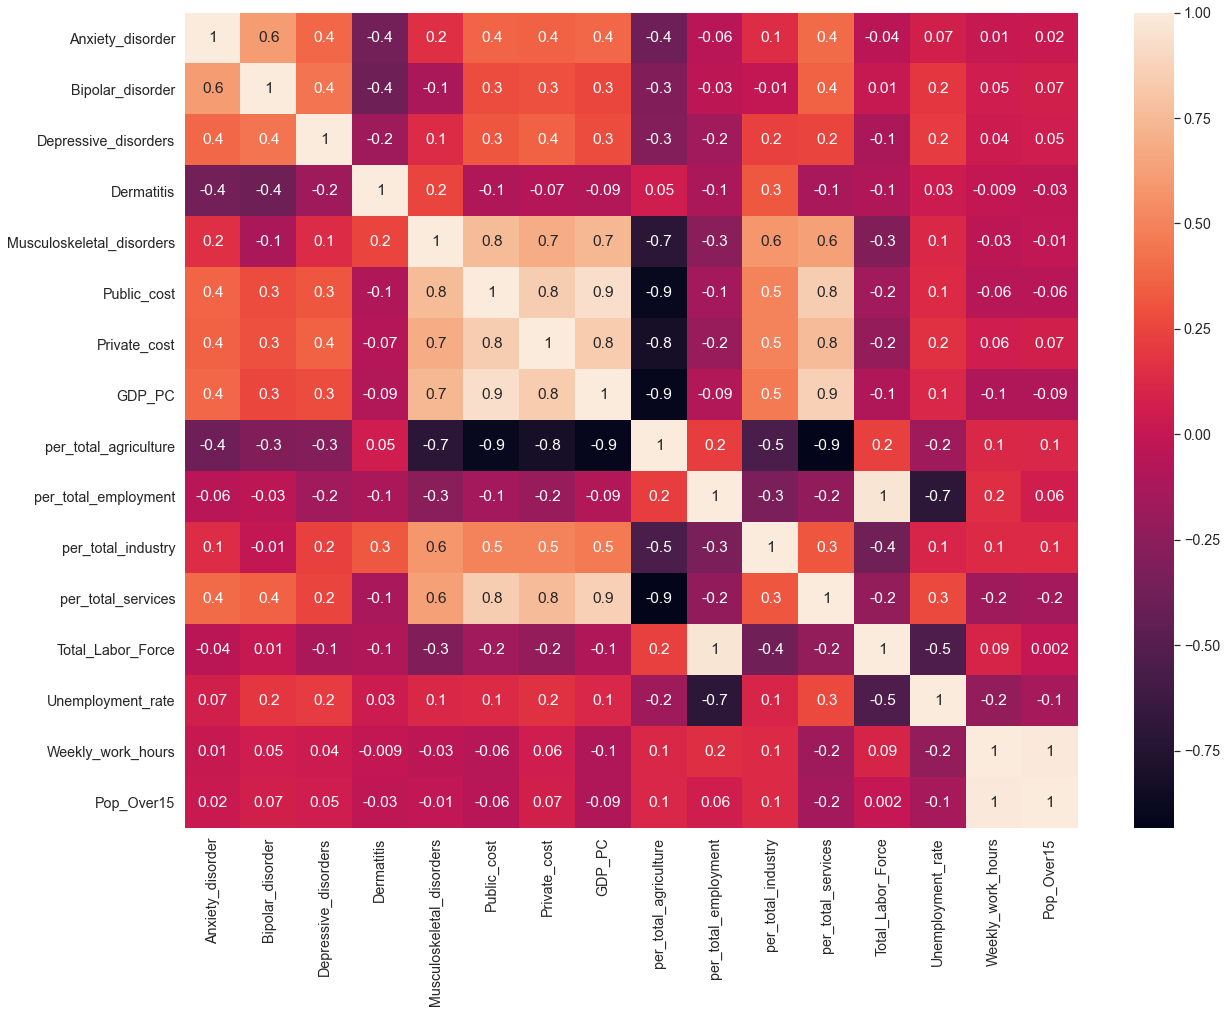

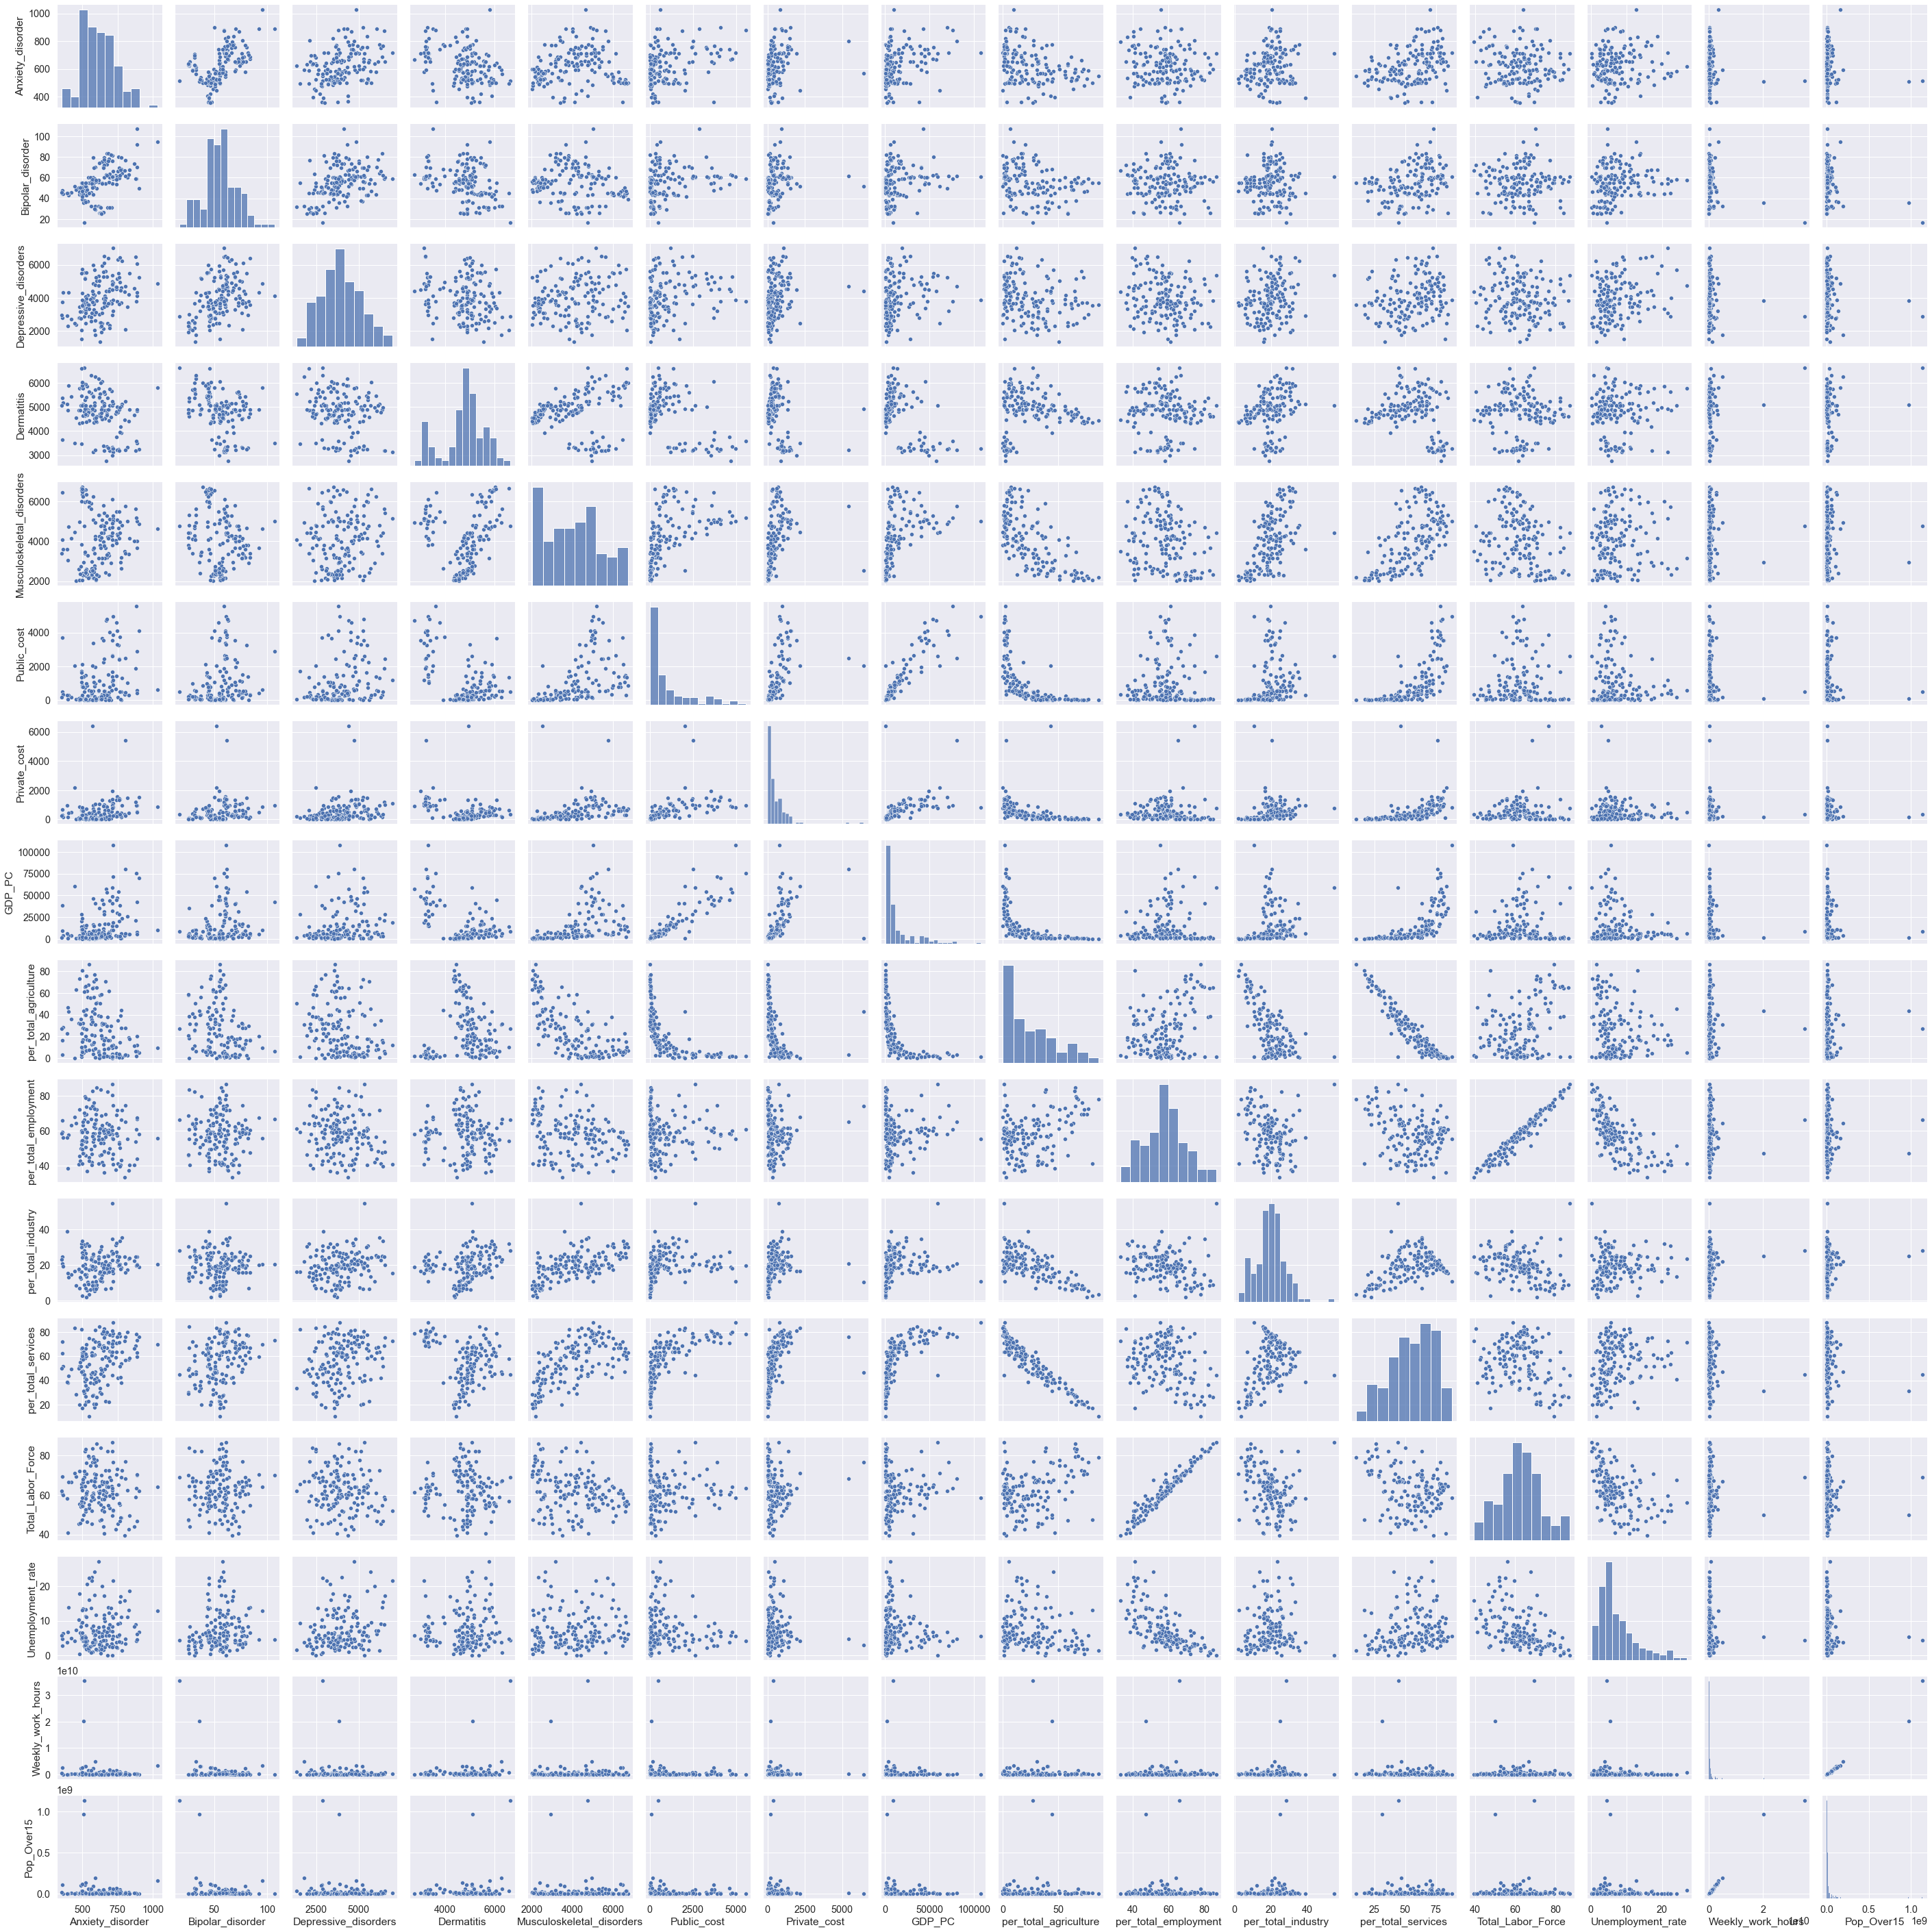

In [29]:
eval_corr(df_17,list(df_17.columns))

### Interesting correlations:
	
* Musc. Disorders & GDP_PC -> 0,7
* Musc. Disorders & Public_Cost -> 0,8
* Musc. Disorders & Private_Cost -> 0,7
* Musc. Disorders & per_total_agric -> -0,7
	
* Public_Cost & per_total_services -> 0,8
* Public_Cost & per_total_agriculture -> -0,9
* Public_Cost & GDP_PC -> 0,9
* Public_Cost & Private_Cost -> 0,8
	
* Private_Cost & per_total_services -> 0,8
* Private_Cost & per_total_agriculture -> -0,8
* Private_cost & GDP_PC -> 0,8
	
* GDP_PC & per_total_services -> 0,9
* GDP_PC & per_total_agric -> -0,9
	
* per_total_agriculture & per_total_services -> -0,9
	
* per_total_employment & Week_hours_PC -> 0,8
* per_total_employment & Unemp_rate -> -0,7
	
* Anxiety & Bipolar -> 0,6

#### Musc. Disorders & per_total_agriculture
* Negative correlation (-0.7)
* The more percentage the country has in agriculture, the less musc. diseases they have

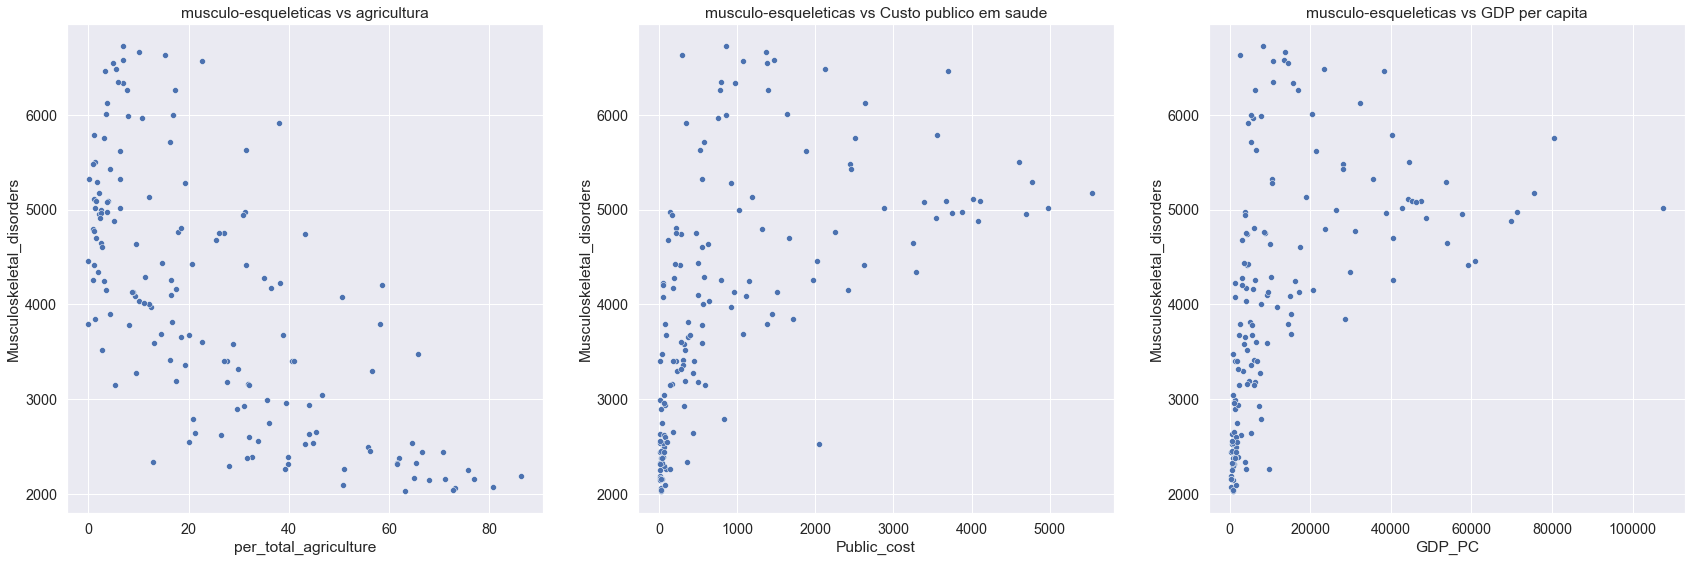

In [30]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17, x='per_total_agriculture',y= 'Musculoskeletal_disorders', ax=axes[0]).set_title('musculo-esqueleticas vs agricultura')
sns.scatterplot(data=df_17, x='Public_cost',y= 'Musculoskeletal_disorders', ax=axes[1]).set_title('musculo-esqueleticas vs Custo publico em saude')
sns.scatterplot(data=df_17, x='GDP_PC',y= 'Musculoskeletal_disorders', ax=axes[2]).set_title('musculo-esqueleticas vs GDP per capita')

plt.show()


* Countries with higher incidence of Musculoskeletical diseases are the ones that have:
1. smaller agriculture sector share of employees
2. Spend more in public health costs
3. Higher GDP_PC (more developped countries might mean less agriculture)

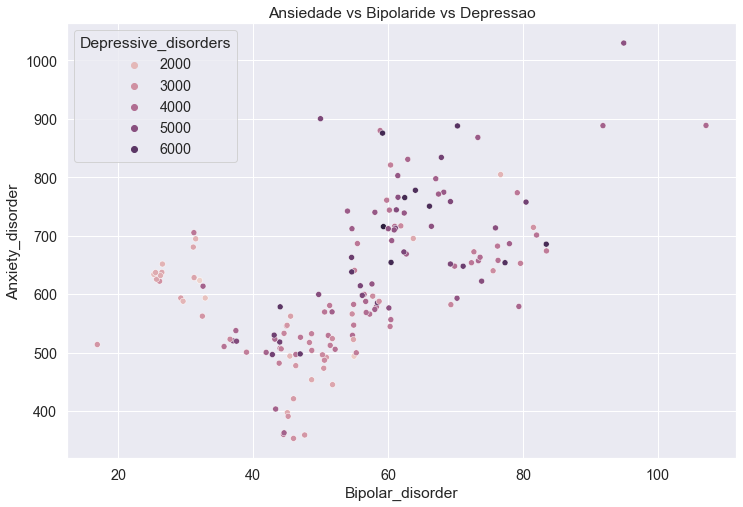

In [31]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df_17, x='Bipolar_disorder',y= 'Anxiety_disorder', hue = 'Depressive_disorders')\
.set_title('Ansiedade vs Bipolaride vs Depressao')
                
plt.show()

* Countries with higher incidence of Bipolar disorders are also the ones with higher incidence of Anxiety Disorders. Since these are both work related menatal diseases, we are going to group them into a single "mental disorder" category along with depression disorders (which has a positive correlation - although of smaller magnitude with the previous ones)

### Feature engineering

#### Feature Engineering steps:

1. Group all mental diseases (incidences per 100000 pp) in a single variable:
    * __mental_disorders = anxiety_disorder + bipolar_disorder + depressive_disorder__
2. Group Public_cost and Private_Cost in a single variable:
    * __total_health_cost = Private_cost + Public_cost__
4. the unemployment rate is a percentage over the total labor force. If we multiply it by the percentage of labor force over the whole population, we get the unemployment rate per Capita (__Unemp_PC__)
5. The variable __Weekly_work_hours__ is the complete amount of hours worked by employed persons on average per country. If we divide it by the number of employed persons, we get the average amount of hours worked per person (__Week_hours_PC__)

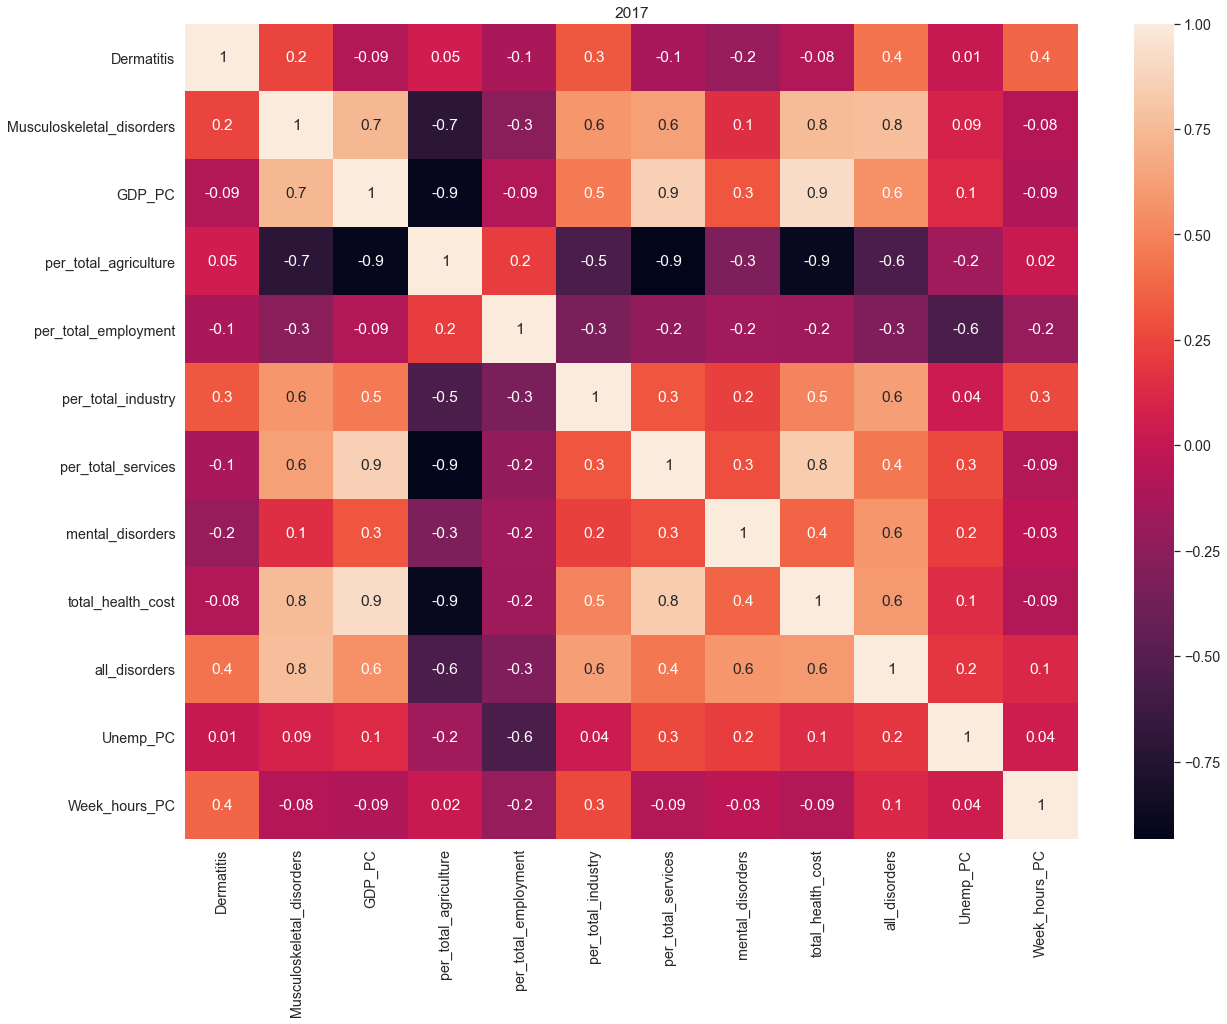

In [32]:
df_17_feat = feature_df(df_17,'2017')

### Exploration with new features

* __all_disorders__(total incidence of work related disorders) shows:
    1. Some correlation with the __GDP_PC__ (0.6) -> Countries with higher GDP tend to have more work related disorders.
    2. Some correlation with __total_health_cost__ (0.6) --> Countries with higher incidence on work related disorders tend to spend more money in health (these are also countries that tend to have higher GDP and therefore more developped)
    3. Some correlation with __per_total_industry__ (0.6) --> Countries with higher share in industry tend to have more work related disorders and less __per_total_agriculture__ (-0.6)
    
* __Week_hours_PC__ (average amount of hours worked per an employed person) shows:
    1. almost unexisting correlation with all variables except with Dermatitis (but still low correlation = 0.4)
    

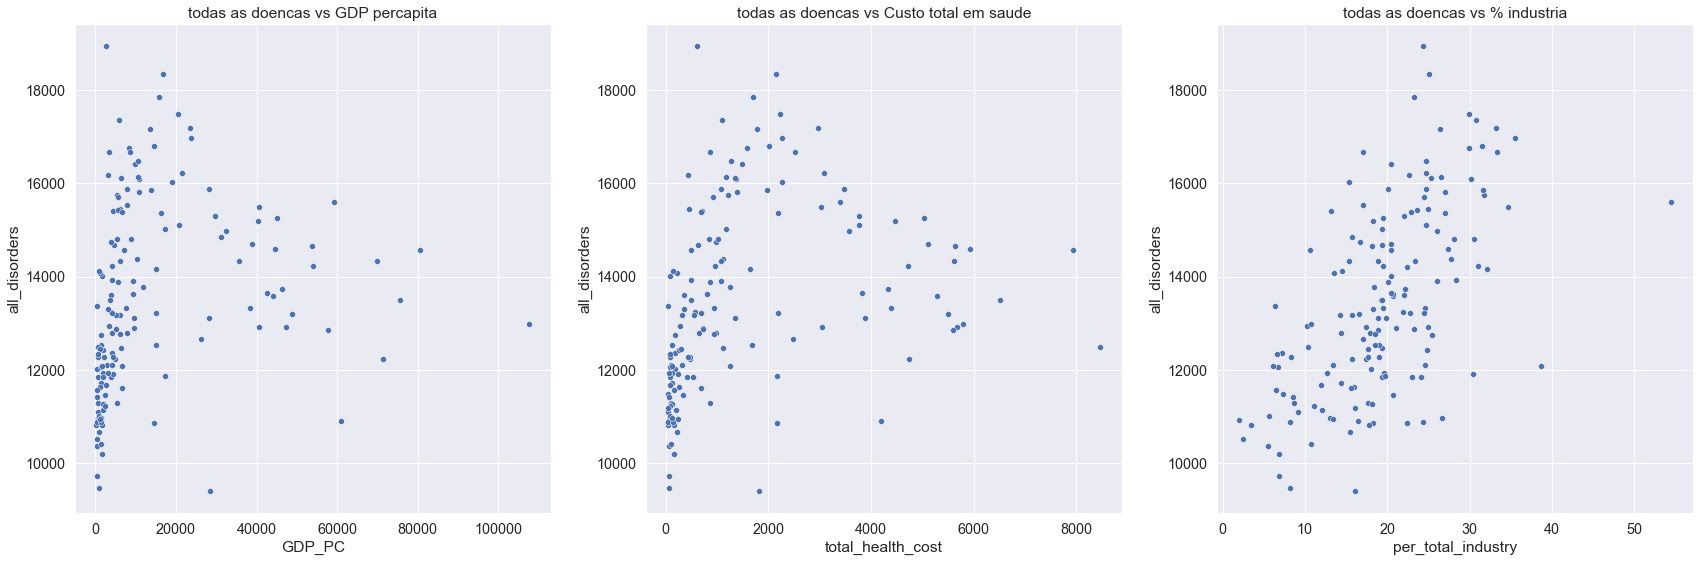

In [33]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17_feat, x='GDP_PC',y= 'all_disorders', ax=axes[0]).set_title('todas as doencas vs GDP percapita')
sns.scatterplot(data=df_17_feat, x='total_health_cost',y= 'all_disorders', ax=axes[1]).set_title('todas as doencas vs Custo total em saude')
sns.scatterplot(data=df_17_feat, x='per_total_industry',y= 'all_disorders', ax=axes[2]).set_title('todas as doencas vs % industria')

plt.show()

In [34]:
df_17_feat.describe().T

count          mean           std          min  \
Dermatitis                 157.0   4768.037525    844.724435  2755.356948   
Musculoskeletal_disorders  157.0   4039.164143   1317.712702  2032.008510   
GDP_PC                     154.0  14207.364795  19318.796434   292.997631   
per_total_agriculture      157.0     24.982102     22.223413     0.060000   
per_total_employment       157.0     57.914522     11.509101    33.189999   
per_total_industry         157.0     19.492611      7.898400     1.970000   
per_total_services         157.0     55.526624     17.969138    10.220000   
mental_disorders           157.0   4652.974367   1224.596879  2011.980909   
total_health_cost          151.0   1529.857132   1827.833980    37.519101   
all_disorders              157.0  13460.176035   2022.573882  9399.809067   
Unemp_PC                   157.0      0.043023      0.029701     0.001152   
Week_hours_PC              156.0     39.723777      4.568705    24.763121   

                                    25%           50%           75%  \
Dermatitis                  4441.318473   4877.088127   5236.099278   
Musculoskeletal_disorders   2898.477911   4077.581955   4977.676623   
GDP_PC                      1862.066374   5759.222785  16723.603844   
per_total_agriculture          5.560000     18.480000     38.759998   
per_total_employment          49.599998     58.250000     65.040001   
per_total_industry            15.410000     19.379999     24.540001   
per_total_services            42.810001     58.799999     69.830002   
mental_disorders            3787.684519   4546.854334   5510.683400   
total_health_cost            186.617944    837.768982   2169.380463   
all_disorders              11917.457008  13208.057032  14987.158698   
Unemp_PC                       0.023400      0.035356      0.052351   
Week_hours_PC                 36.708340     39.591867     42.537114   

                                     max  
Dermatitis                   6626.683024  
Musculoskeletal_disorders    6725.235781  
GDP_PC                     107627.151007  
per_total_agriculture          86.309998  
per_total_employment           86.709999  
per_total_industry             54.509998  
per_total_services             87.849998  
mental_disorders             7769.331191  
total_health_cost            8466.585693  
all_disorders               18944.856987  
Unemp_PC                        0.163650  
Week_hours_PC                  52.412852

### Missing Values
(Using the Gradient Boosting)

In [35]:
pd.DataFrame({'#NA: 2017': df_17_feat.isna().sum()})

#NA: 2017
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             3
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  6
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      1

In [36]:
df_17_feat.loc[df_17_feat.isnull().any(axis=1)]

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Eritrea               4679.569806                2166.618721           NaN   
Guam                  5376.262523                5321.591138  35615.804627   
Libya                 4890.627687                4164.672267   5756.698450   
Montenegro            5625.437399                5989.258728   7784.087912   
Puerto Rico           5640.453543                4770.363208  31108.752751   
Somalia               4348.425869                2072.495370    309.055355   
South Sudan           4441.318473                2314.572942           NaN   
Syrian Arab Republic  4675.800606                4011.530808           NaN   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Eritrea                           64.889999             74.190002   
Guam                               0.250000             60.869999   
Libya                             17.580000             40.450001   
Montenegro                         7.940000             44.759998   
Puerto Rico                        1.130000             36.099998   
Somalia                           80.690002             41.310001   
South Sudan                       61.660000             63.590000   
Syrian Arab Republic              11.220000             40.500000   

                      per_total_industry  per_total_services  \
location_name                                                  
Eritrea                         7.350000           27.750000   
Guam                           15.310000           84.440002   
Libya                          23.620001           58.799999   
Montenegro                     17.080000           74.980003   
Puerto Rico                    15.680000           83.190002   
Somalia                         2.460000           16.840000   
South Sudan                    16.080000           22.270000   
Syrian Arab Republic           22.420000           66.360001   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Eritrea                    4631.311374          40.910640   11477.499901   
Guam                       3642.804994                NaN   14340.658655   
Libya                      6382.385393                NaN   15437.685347   
Montenegro                 3930.535277                NaN   15545.231405   
Puerto Rico                4434.755309                NaN   14845.572060   
Somalia                    4097.692861                NaN   10518.614101   
South Sudan                4418.141543          47.142034   11174.032958   
Syrian Arab Republic       5510.683400                NaN   14198.014814   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Eritrea               0.051577            NaN  
Guam                  0.035356      42.518226  
Libya                 0.092492      43.942724  
Montenegro            0.085717      42.917924  
Puerto Rico           0.043708      38.002861  
Somalia               0.061845      36.250964  
South Sudan           0.088619      36.192864  
Syrian Arab Republic  0.036802      42.196742

In [37]:
df_17_gb = (
    df_17_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Week_hours_PC')
)

In [38]:
df_17_gb.loc[df_17_feat.isnull().any(axis=1)]
# Gradient Boosting imputed a negative total_health_cost value for Somalia, which should be corrected.
#To simplify the analysis, this line will be removed, along with outliers

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Eritrea               4679.569806                2166.618721   1105.176307   
Guam                  5376.262523                5321.591138  35615.804627   
Libya                 4890.627687                4164.672267   5756.698450   
Montenegro            5625.437399                5989.258728   7784.087912   
Puerto Rico           5640.453543                4770.363208  31108.752751   
Somalia               4348.425869                2072.495370    309.055355   
South Sudan           4441.318473                2314.572942    802.363038   
Syrian Arab Republic  4675.800606                4011.530808   7425.400217   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Eritrea                           64.889999             74.190002   
Guam                               0.250000             60.869999   
Libya                             17.580000             40.450001   
Montenegro                         7.940000             44.759998   
Puerto Rico                        1.130000             36.099998   
Somalia                           80.690002             41.310001   
South Sudan                       61.660000             63.590000   
Syrian Arab Republic              11.220000             40.500000   

                      per_total_industry  per_total_services  \
location_name                                                  
Eritrea                         7.350000           27.750000   
Guam                           15.310000           84.440002   
Libya                          23.620001           58.799999   
Montenegro                     17.080000           74.980003   
Puerto Rico                    15.680000           83.190002   
Somalia                         2.460000           16.840000   
South Sudan                    16.080000           22.270000   
Syrian Arab Republic           22.420000           66.360001   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Eritrea                    4631.311374          40.910640   11477.499901   
Guam                       3642.804994        4006.757605   14340.658655   
Libya                      6382.385393         658.580068   15437.685347   
Montenegro                 3930.535277        1742.846834   15545.231405   
Puerto Rico                4434.755309        2954.112637   14845.572060   
Somalia                    4097.692861         -27.362082   10518.614101   
South Sudan                4418.141543          47.142034   11174.032958   
Syrian Arab Republic       5510.683400        1103.179112   14198.014814   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Eritrea               0.051577      33.146123  
Guam                  0.035356      42.518226  
Libya                 0.092492      43.942724  
Montenegro            0.085717      42.917924  
Puerto Rico           0.043708      38.002861  
Somalia               0.061845      36.250964  
South Sudan           0.088619      36.192864  
Syrian Arab Republic  0.036802      42.196742

### 1. Remove Outliers

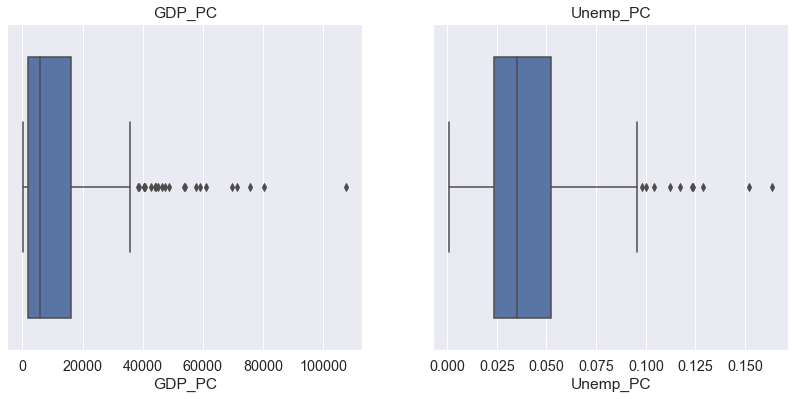

skew      kurt
Dermatitis                -0.467853 -0.241363
Musculoskeletal_disorders  0.229870 -0.958559
GDP_PC                     2.132451  4.813585
per_total_agriculture      0.849607 -0.275752
per_total_employment       0.155255 -0.351983
per_total_industry         0.433400  1.693261
per_total_services        -0.411677 -0.691903
mental_disorders           0.251585 -0.468637
total_health_cost          1.570708  1.916258
all_disorders              0.326363 -0.580497
Unemp_PC                   1.521677  2.593211
Week_hours_PC             -0.294337  0.731803

In [39]:
eval_outliers(df_17_gb,['GDP_PC','Unemp_PC'])

In [40]:
#check removal data: outliers & errors
pd.concat([df_17_gb.loc[df_17_gb.Unemp_PC > 0.14],df_17_gb.loc[df_17_gb.GDP_PC > 65000],df_17_gb.loc[df_17_gb.total_health_cost < 0]])

Dermatitis  Musculoskeletal_disorders         GDP_PC  \
location_name                                                          
Lesotho        5074.161492                2652.758050    1150.079174   
South Africa   5764.945270                3152.868063    6131.479450   
Iceland        3265.699416                4977.676623   71310.939256   
Ireland        3260.744705                4876.256807   69822.347085   
Luxembourg     3288.160994                5022.600800  107627.151007   
Norway         3596.558229                5178.138695   75496.754058   
Switzerland    3222.047159                5755.426880   80449.994513   
Somalia        4348.425869                2072.495370     309.055355   

               per_total_agriculture  per_total_employment  \
location_name                                                
Lesotho                    45.430000             51.450001   
South Africa                5.280000             40.990002   
Iceland                     3.760000             74.540001   
Ireland                     5.050000             58.020000   
Luxembourg                  1.390000             55.430000   
Norway                      2.060000             60.950001   
Switzerland                 3.110000             65.099998   
Somalia                    80.690002             41.310001   

               per_total_industry  per_total_services  mental_disorders  \
location_name                                                             
Lesotho                     13.51           41.049999       6347.787924   
South Africa                23.34           71.379997       5414.936949   
Iceland                     17.48           78.760002       3984.293983   
Ireland                     18.84           76.110001       6201.472427   
Luxembourg                  10.76           87.849998       4667.434135   
Norway                      19.41           78.529999       4725.965084   
Switzerland                 20.52           76.379997       5586.305732   
Somalia                      2.46           16.840000       4097.692861   

               total_health_cost  all_disorders  Unemp_PC  Week_hours_PC  
location_name                                                             
Lesotho               225.718815   14074.707465  0.163650      39.593927  
South Africa         1068.719543   14332.750282  0.151911      42.275911  
Iceland              4739.734131   12227.670022  0.020999      38.747265  
Ireland              5616.831787   14338.473940  0.041736      35.810822  
Luxembourg           5789.332764   12978.195929  0.032386      37.361508  
Norway               6515.912048   13500.662008  0.026458      34.524246  
Switzerland          7928.174316   14563.779771  0.032822      36.468699  
Somalia               -27.362082   10518.614101  0.061845      36.250964

In [41]:
index_2_remove = pd.concat([df_17_gb.loc[df_17_gb.Unemp_PC > 0.14],df_17_gb.loc[df_17_gb.GDP_PC > 65000],df_17_gb.loc[df_17_gb.total_health_cost < 0]]).index
df_17_no = df_17_gb.drop(index = list(index_2_remove))

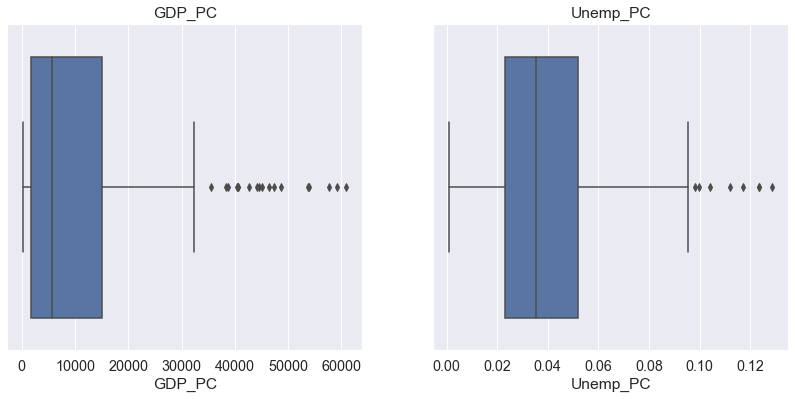

skew      kurt
Dermatitis                -0.519303  0.027493
Musculoskeletal_disorders  0.269193 -0.919017
GDP_PC                     1.680599  1.870425
per_total_agriculture      0.813176 -0.320044
per_total_employment       0.155942 -0.336038
per_total_industry         0.454994  1.667615
per_total_services        -0.397260 -0.677037
mental_disorders           0.286475 -0.456559
total_health_cost          1.635068  2.438804
all_disorders              0.336484 -0.639516
Unemp_PC                   1.195441  1.094366
Week_hours_PC             -0.351571  0.732519

In [42]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_17_no,['GDP_PC','Unemp_PC'])

## Cluster Analysis

### Correlation check

### Scenario 1: __For 2017__, considering the following features:

1. per_total_employment -> removed (leave only one labor overall indicator)
2. __Unemp_PC__
3. __Week_hours_PC__
4. GDP_PC (__high corr__) -> removed
5. total_health_cost (__high corr__) -> removed
6. __All_disorders__
7. __per_total_services__
8. per_total_industry -> remove (medium high correlation to services)

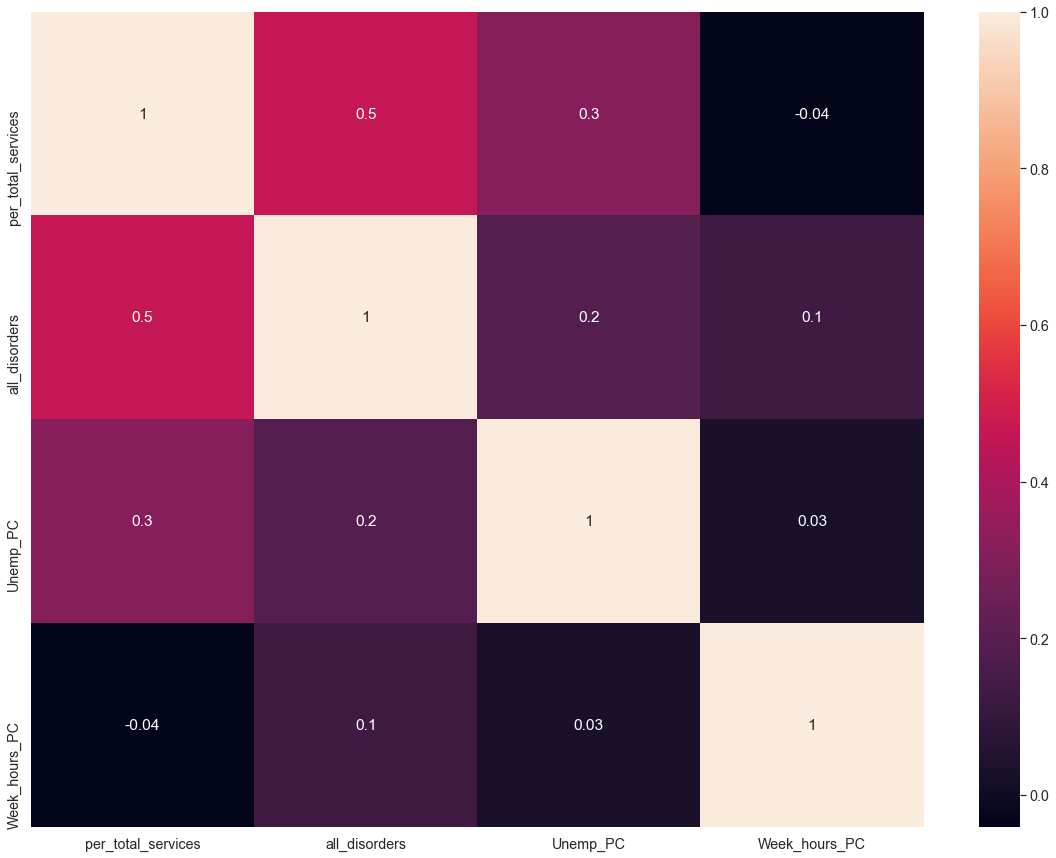

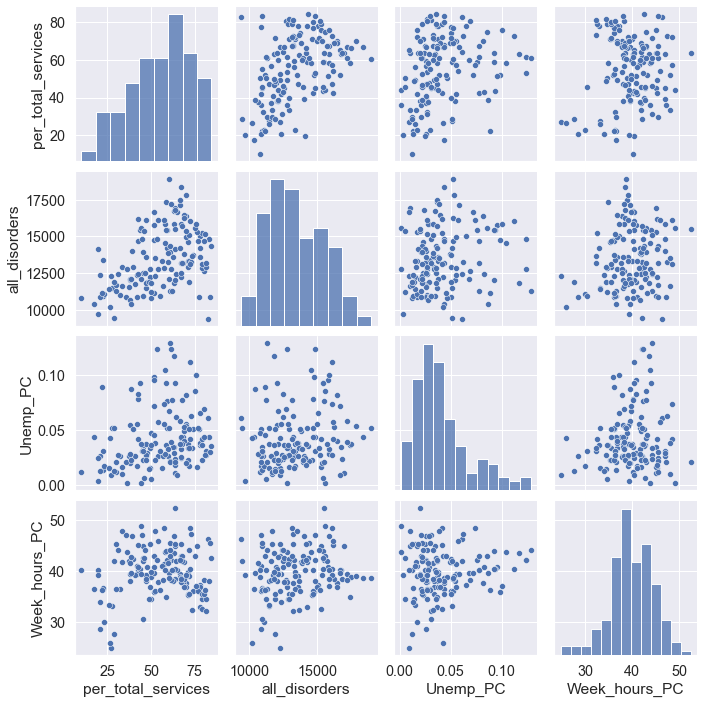

In [43]:
#cols_eval = ['per_total_employment', 'per_total_industry',
#       'per_total_services',
#       'all_disorders', 'Unemp_PC', 'Week_hours_PC']

cols_eval = ['per_total_services','all_disorders', 'Unemp_PC', 'Week_hours_PC']
             
eval_corr(df_17_no,cols_eval)

In [44]:
df_sc_1 = df_17_no[cols_eval]

### Evaluate normality of distributions

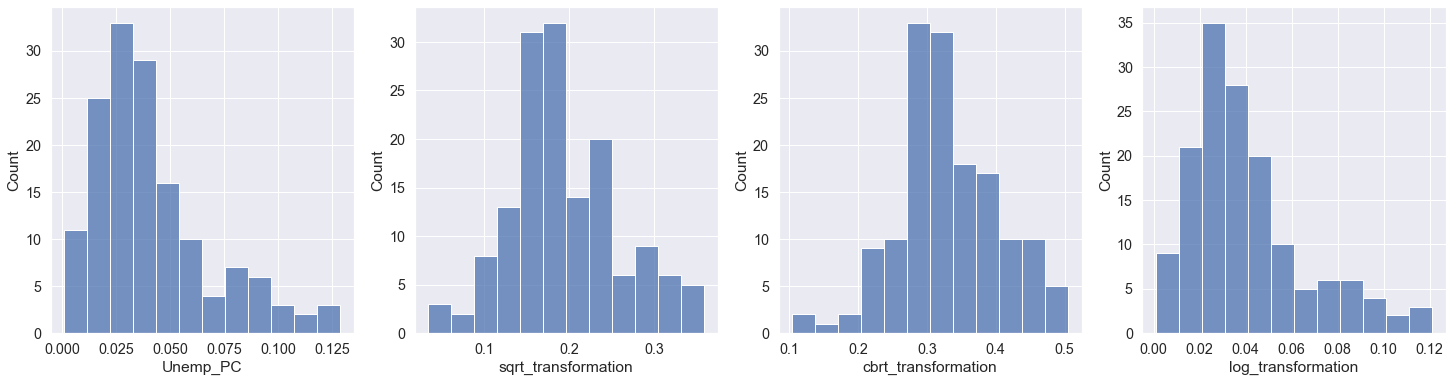

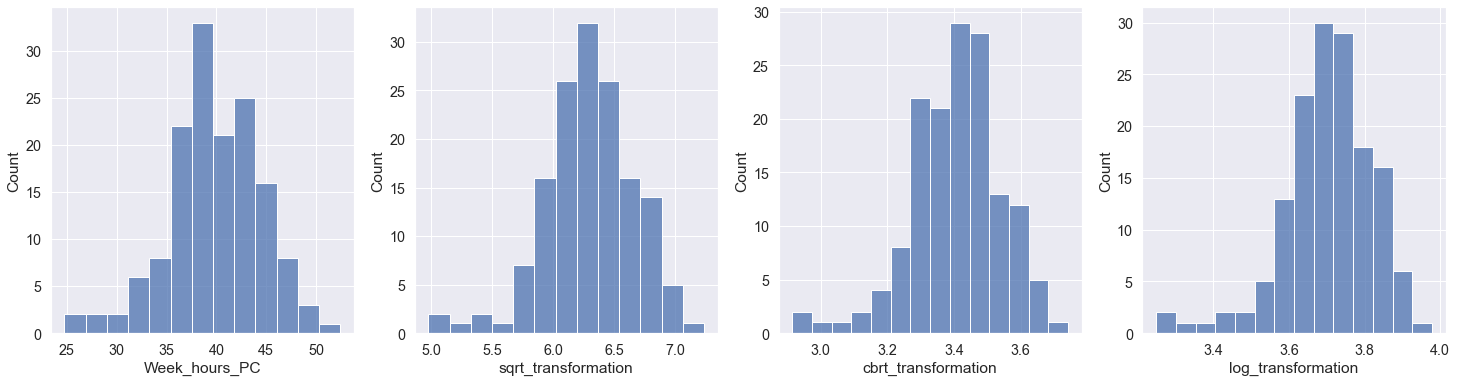

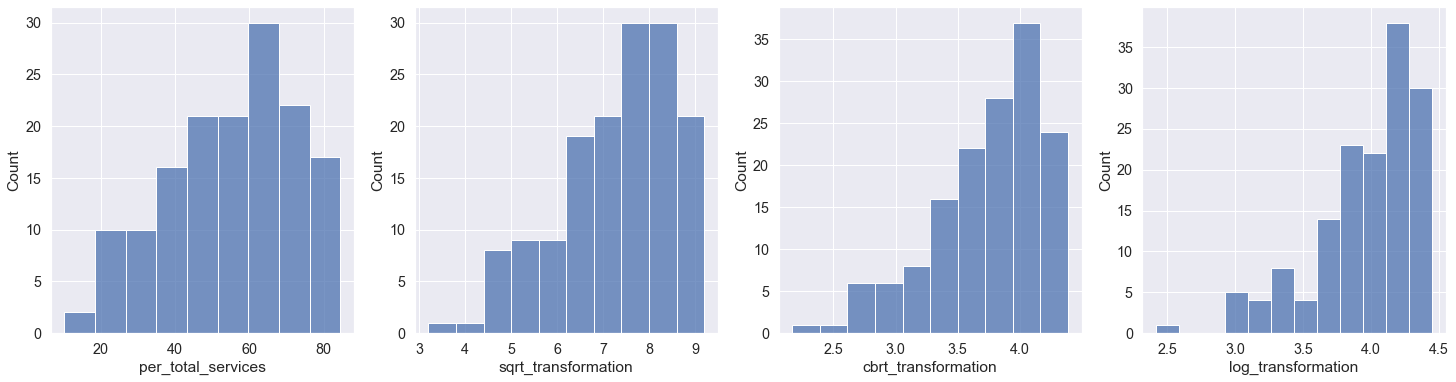

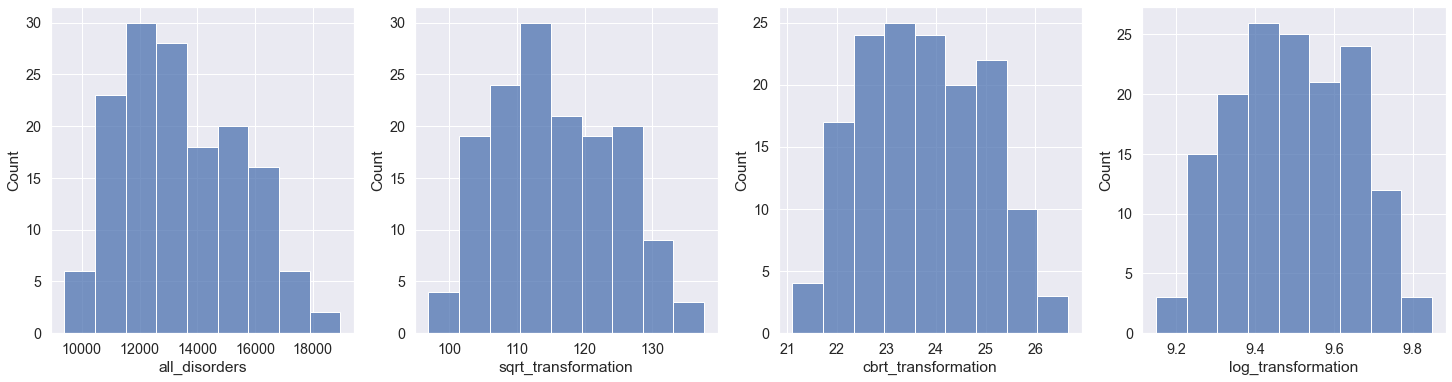

In [45]:
pt_evaluation(df_sc_1, 'Unemp_PC')
pt_evaluation(df_sc_1, 'Week_hours_PC')
pt_evaluation(df_sc_1, 'per_total_services')
pt_evaluation(df_sc_1, 'all_disorders')
#pt_evaluation(df_sc_1, 'per_total_industry')
#pt_evaluation(df_sc_1, 'per_total_employment')

In [46]:
df_sc1_t = df_sc_1[[]]
df_sc1_t = df_sc1_t.assign(Unemp_PC_cb = np.sqrt(df_sc_1['Unemp_PC']))
df_sc1_t = df_sc1_t.assign(Week_hours_PC_norm = (df_sc_1['Week_hours_PC']))
df_sc1_t = df_sc1_t.assign(per_total_services_norm = (df_sc_1['per_total_services']))
df_sc1_t = df_sc1_t.assign(all_disorders_cb = np.cbrt(df_sc_1['all_disorders']))
#df_sc1_t = df_sc1_t.assign(per_total_industry_cb = np.cbrt(df_sc_1['per_total_industry']))
#df_sc1_t = df_sc1_t.assign(per_total_employment_norm = (df_sc_1['per_total_employment']))

<AxesSubplot:>

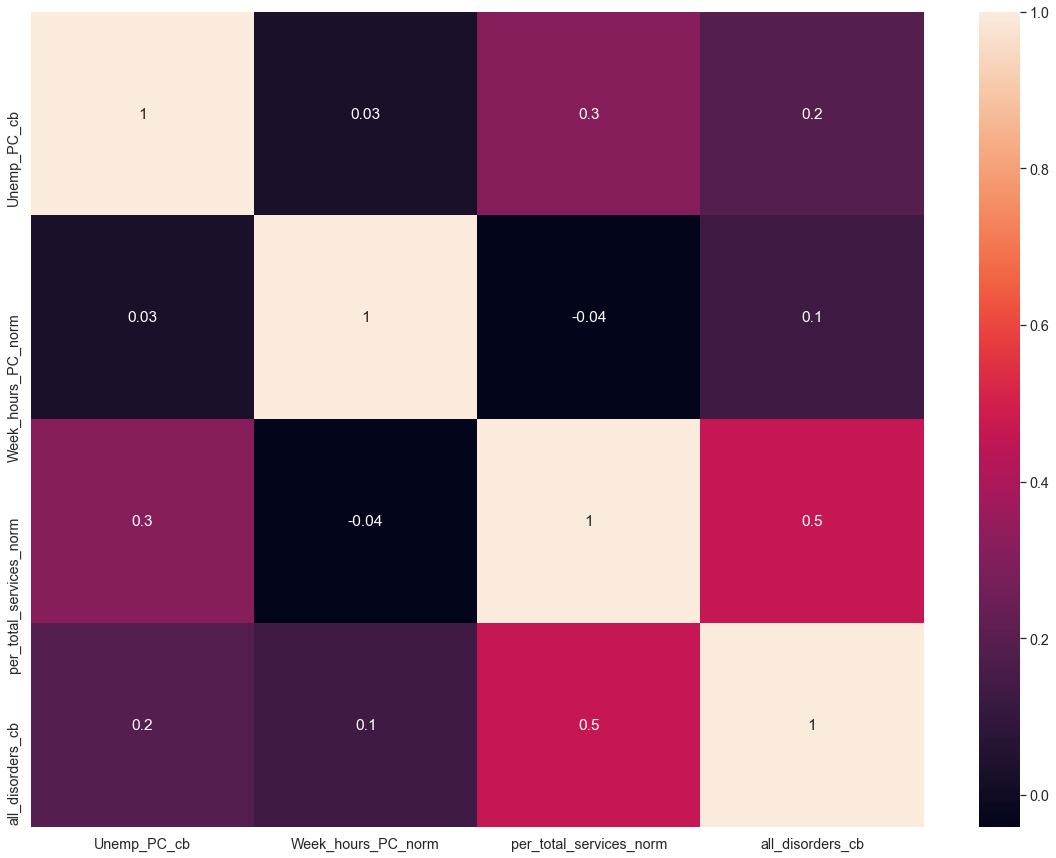

In [47]:
sns.set(font_scale=1.3)
df_corr = df_sc1_t.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

In [48]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc1_t), columns=df_sc1_t.columns)

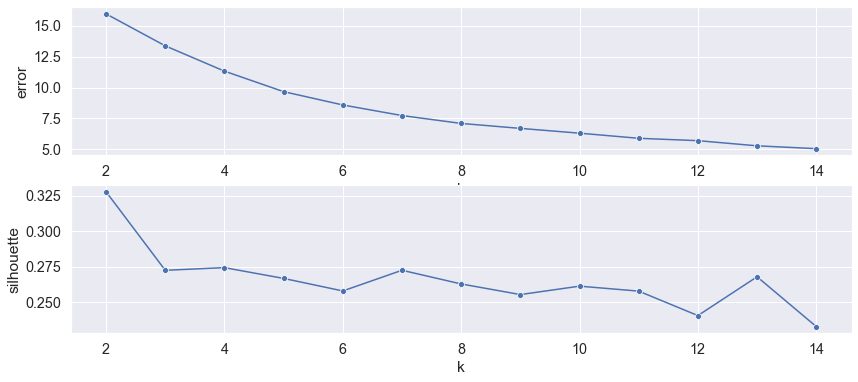

In [49]:
evaluate_number_clusters(minmax_sc1,15)

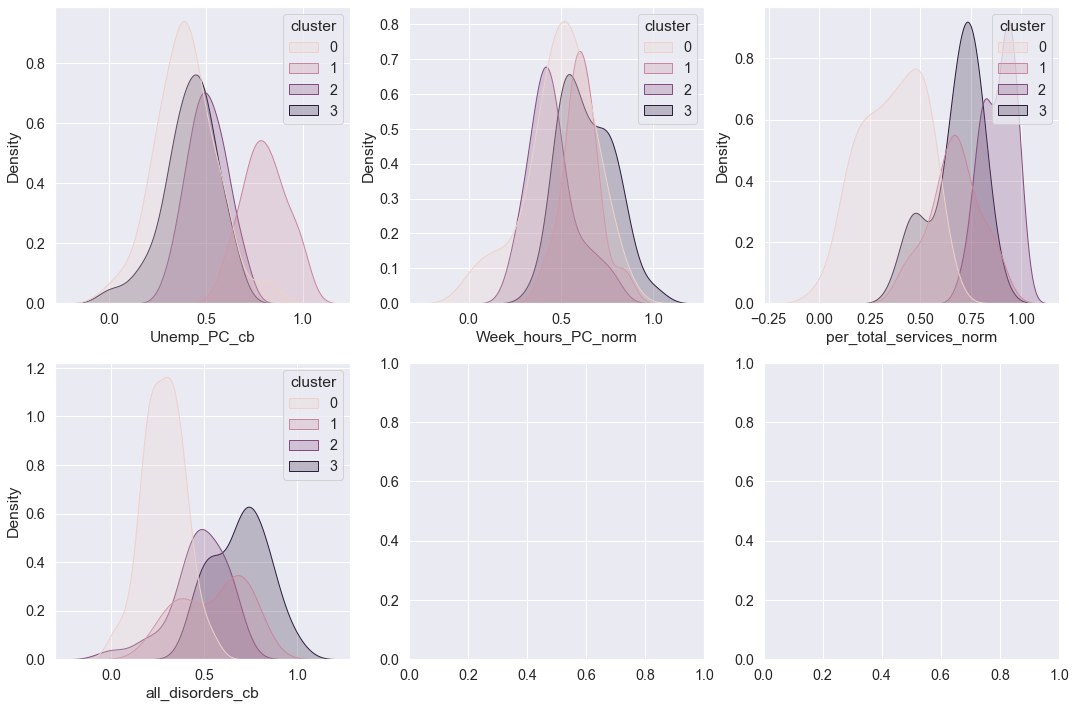

In [55]:
df_cluster_17, kmeans = evaluate_cluster(minmax_sc1, df_sc_1, 4)

In [83]:
df_cluster_17

per_total_services  all_disorders  Unemp_PC  Week_hours_PC  \
location_name                                                               
Afghanistan             37.990002   12019.801306  0.054413      37.965054   
Albania                 42.540001   14681.412913  0.077770      40.176507   
Algeria                 58.849998   14235.942985  0.051360      41.701073   
Angola                  41.820000   12354.361257  0.055075      39.386274   
Argentina               77.500000   10849.770449  0.050593      36.007197   
...                           ...            ...       ...            ...   
Uruguay                 71.519997   11864.914500  0.050662      35.518234   
Uzbekistan              49.799999   11835.261443  0.036001      39.721078   
Vanuatu                 28.770000   11920.962552  0.012238      27.549098   
Zambia                  38.599998   10416.089651  0.087062      39.589807   
Zimbabwe                26.629999   10183.847402  0.042812      25.850283   

               labels  
location_name          
Afghanistan         0  
Albania             1  
Algeria             1  
Angola              0  
Argentina           2  
...               ...  
Uruguay             2  
Uzbekistan          0  
Vanuatu             0  
Zambia              0  
Zimbabwe            0  

[149 rows x 5 columns]

In [190]:
df_aggreg_17 = agreg_clusters(df_cluster_17)
df_aggreg_17 = pd.DataFrame({
    'serv': df_aggreg_17[('labels','count')],
    'all_dis':df_aggreg_17[('all_disorders','mean')],
    'unemp': df_aggreg_17[('per_total_services','mean')],
    'wk_hrs': df_aggreg_17[('Week_hours_PC','mean')]
    })
df_aggreg_17['cluster'] = [0,1,2,3]

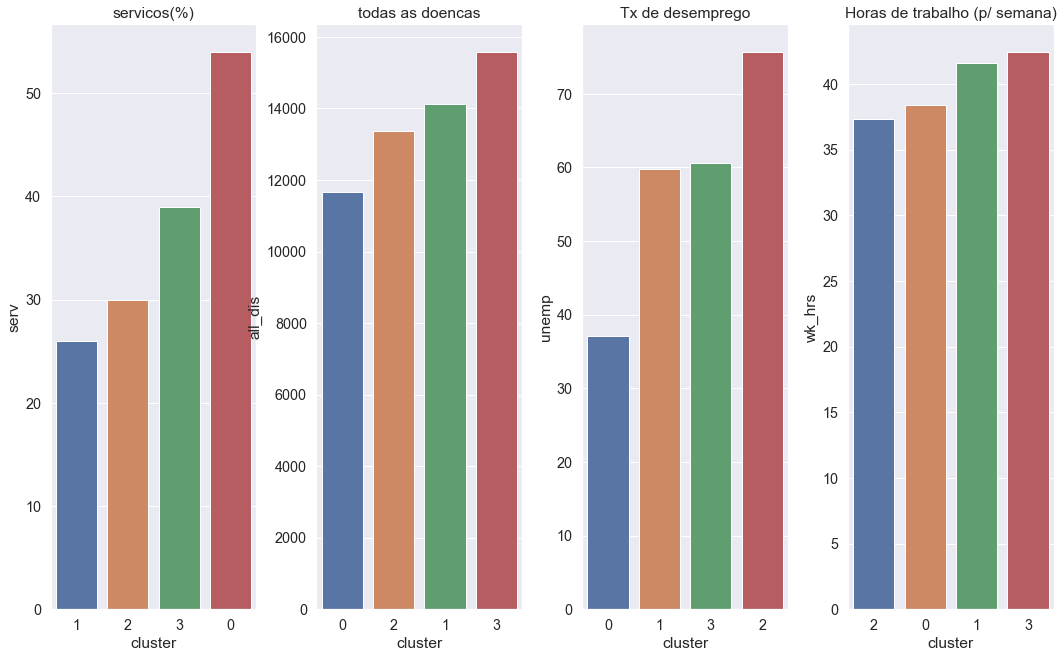

In [193]:
fig, axes = plt.subplots(1, 4, figsize=(15, 9))
fig.tight_layout()
sns.barplot(x="cluster", y="serv", data=df_aggreg_17,ax = axes[0],order=[1,2,3,0]).set_title('servicos(%)')
sns.barplot(x="cluster", y="all_dis", data=df_aggreg_17,ax = axes[1],order=[0,2,1,3]).set_title('todas as doencas')
sns.barplot(x="cluster", y="unemp", data=df_aggreg_17,ax = axes[2],order=[0,1,3,2]).set_title('Tx de desemprego')
sns.barplot(x="cluster", y="wk_hrs", data=df_aggreg_17,ax = axes[3],order=[2,0,1,3]).set_title('Horas de trabalho (p/ semana)')
plt.show()

### Visualize graphically the differences

### Normalize data for the year of 2011

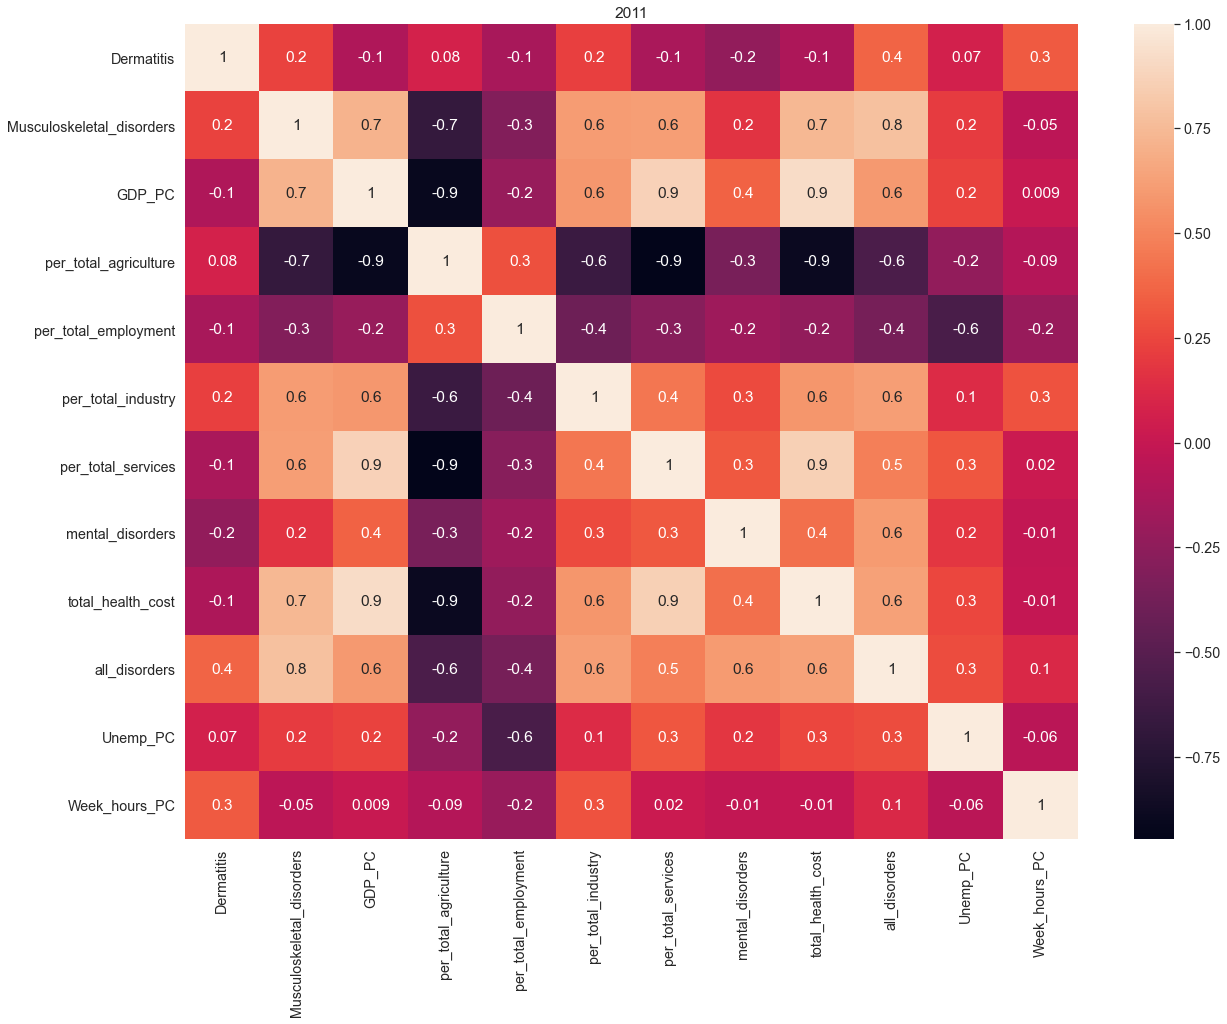

In [68]:
df_11 = merge2complete('2011') ## get full unprocessed df for 2011
df_11_feat = feature_df(df_11,'2011') ## feature eng. df

In [69]:
pd.DataFrame({'#NA: 2011': df_11_feat.isna().sum()})

#NA: 2011
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             2
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  5
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      0

In [70]:
df_11_gb = (
    df_11_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
) ## Fill missing values using GB again

In [71]:
#index_2_remove are the countries removed in the df of 2017. Thse are also going to be removed in 2011
df_11_no = df_11_gb.drop(index = list(index_2_remove))

In [72]:
cols_eval = ['per_total_services','all_disorders', 'Unemp_PC', 'Week_hours_PC']
df_sc_1_11 = df_11_no[cols_eval] ## reduce df to the variables used in this clustering analysis

In [79]:
## Use the same transformations as in 2017
df_sc1_11_t = df_sc_1_11[[]]
df_sc1_11_t = df_sc1_11_t.assign(Unemp_PC_cb = np.sqrt(df_sc_1_11['Unemp_PC']))
df_sc1_11_t = df_sc1_11_t.assign(Week_hours_PC_norm = (df_sc_1_11['Week_hours_PC']))
df_sc1_11_t = df_sc1_11_t.assign(per_total_services_norm = (df_sc_1_11['per_total_services']))
df_sc1_11_t = df_sc1_11_t.assign(all_disorders_cb = np.cbrt(df_sc_1_11['all_disorders']))
#df_sc1_t = df_sc1_t.assign(per_total_industry_cb = np.cbrt(df_sc_1['per_total_industry']))
#df_sc1_t = df_sc1_t.assign(per_total_employment_norm = (df_sc_1['per_total_employment']))

In [80]:
df_sc1_11_t

Unemp_PC_cb  Week_hours_PC_norm  per_total_services_norm  \
location_name                                                             
Afghanistan       0.234461           36.984107                31.690001   
Albania           0.284702           35.917049                35.750000   
Algeria           0.205694           42.242524                58.369999   
Angola            0.238692           39.192026                40.820000   
Argentina         0.208644           38.404798                75.389999   
...                    ...                 ...                      ...   
Uruguay           0.203857           35.868063                69.430000   
Uzbekistan        0.176932           39.737881                50.169998   
Vanuatu           0.113562           27.648823                28.980000   
Zambia            0.280421           39.695580                30.209999   
Zimbabwe          0.210507           25.662696                25.040001   

               all_disorders_cb  
location_name                    
Afghanistan           22.752358  
Albania               24.087852  
Algeria               24.043261  
Angola                23.028870  
Argentina             22.016123  
...                         ...  
Uruguay               22.616543  
Uzbekistan            22.596448  
Vanuatu               22.745303  
Zambia                21.513520  
Zimbabwe              21.434750  

[149 rows x 4 columns]

In [81]:
minmax = MinMaxScaler()
minmax_sc1_11 = pd.DataFrame(minmax.fit_transform(df_sc1_11_t), columns=df_sc1_11_t.columns)

In [91]:
## "Predict" which cluster does each 2011 sample belongs to (in terms of 2017 clsuters)
clusters = kmeans.predict(minmax_sc1_11, sample_weight=None)
df_cluster_11 = df_sc_1_11.assign(labels = clusters)

### Geo visualization of clusters 2011 vs 2017

In [108]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [113]:
def build_geo_df(df_world,df_cluster,df_pop):
    
    df = df_world.copy()
    
    df_code = pd.merge(get_country_code(df_pop),df_cluster, on='location_name',\
                   how='inner')[['Country_Code','labels']]
    
    df_code.set_index('Country_Code',inplace=True)
    
    df.set_index('iso_a3',inplace=True)
    
    df = df.rename_axis('Country_Code')
    
    geo_df = pd.merge(df,df_code,on='Country_Code',how='inner')
    

    #geoplot.choropleth(
    #    geo_df, hue='labels',
    #    cmap='Reds', figsize=(20, 20),categorical = True,
    #    legend = True
    #)
    #plt.figure(figsize=(12,8))
    
    ax = geo_df.plot(column='labels', categorical=True, legend=True, \
                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                             'fmt': "{:.0f}",'title':'cluster label'},figsize=(30, 30)).set_title('World Countries by Cluster')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    
    #return geo_df

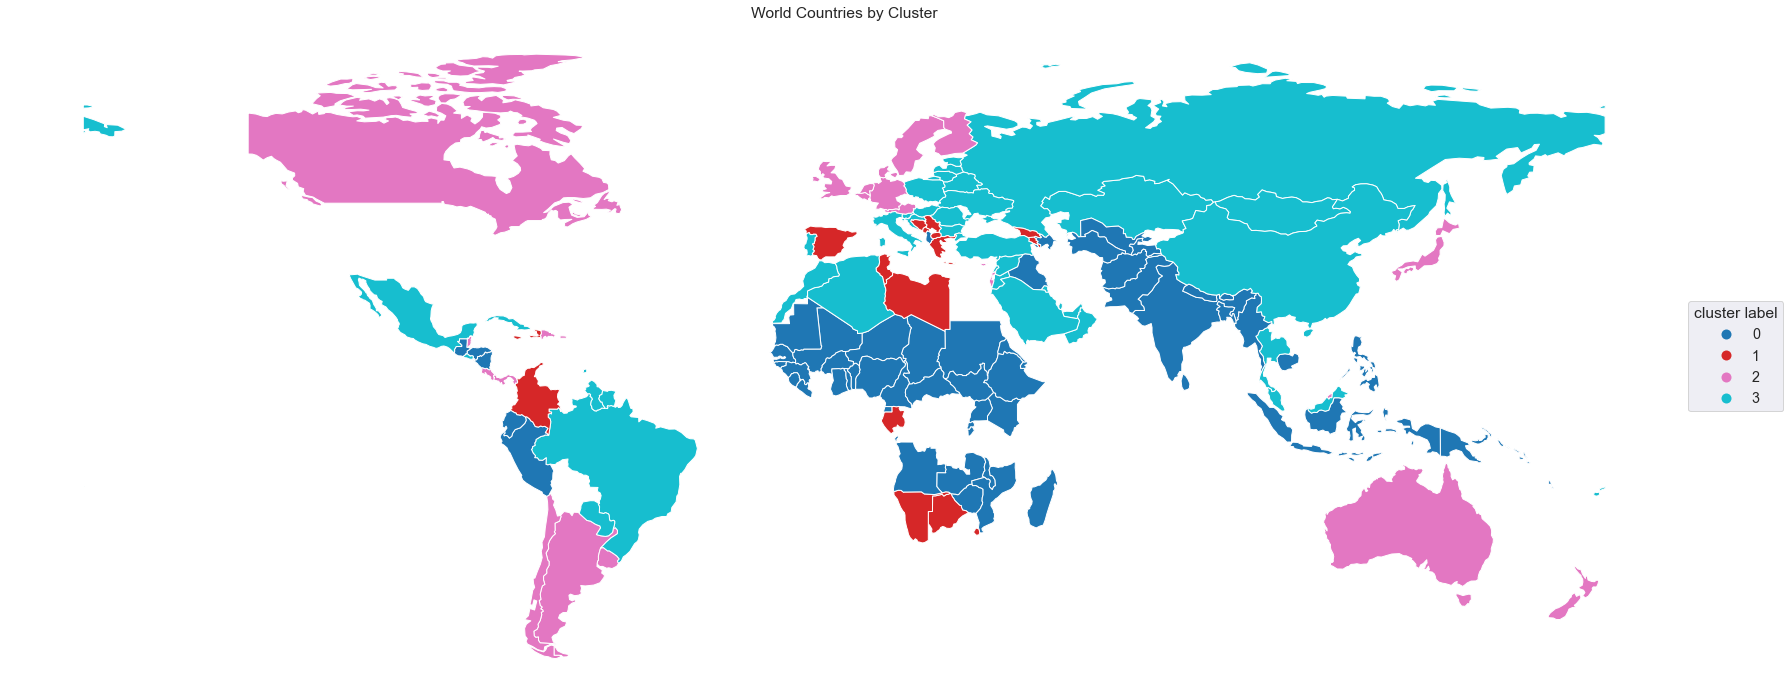

In [114]:
build_geo_df(world,df_cluster_11,df_pop)

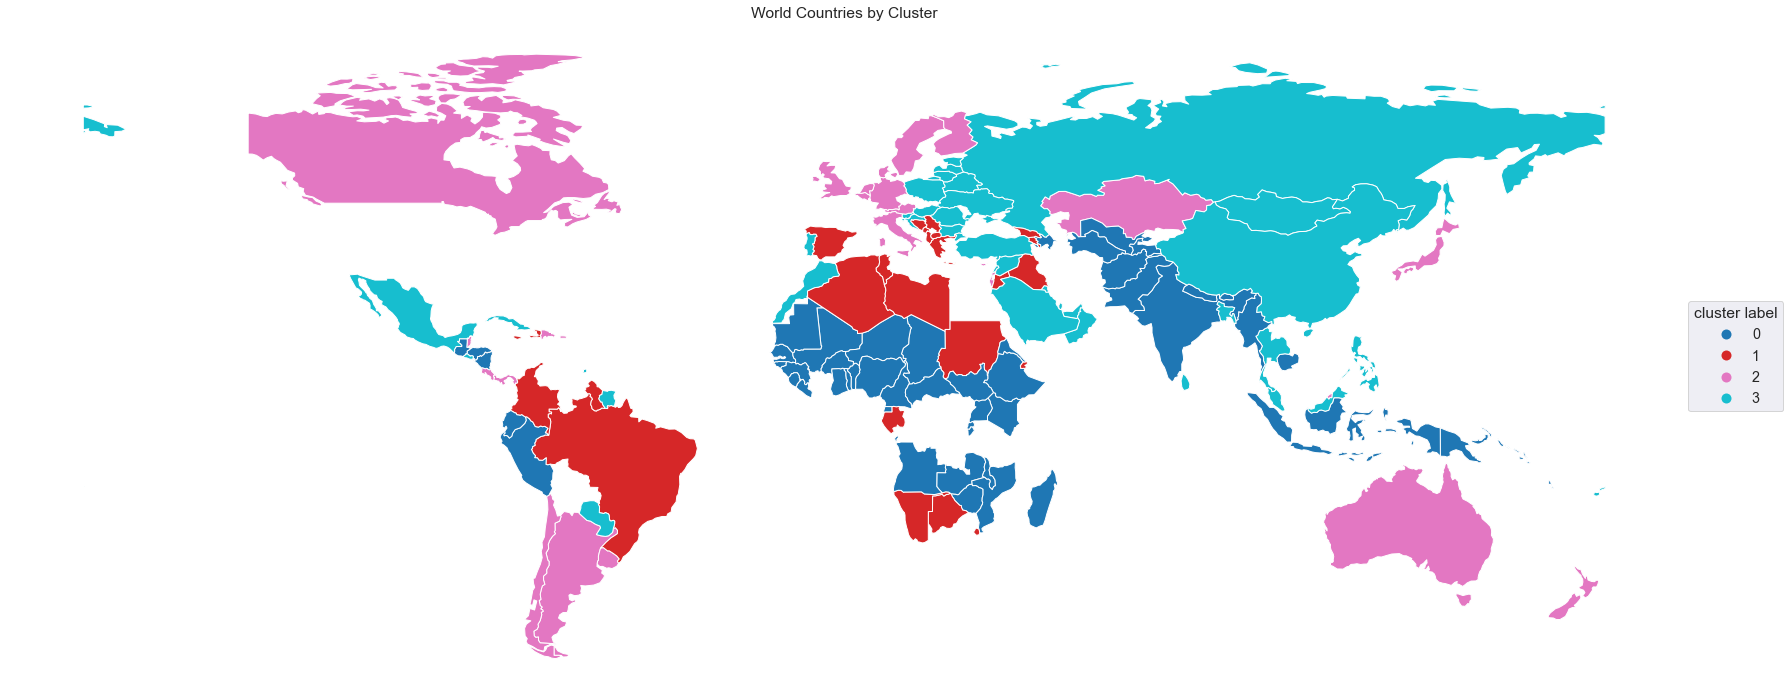

In [115]:
build_geo_df(world,df_cluster_17,df_pop)

In [130]:
df_cluster_17[df_cluster_17.labels != df_cluster_11.labels]

per_total_services  all_disorders  Unemp_PC  Week_hours_PC  \
location_name                                                               
Albania                 42.540001   14681.412913  0.077770      40.176507   
Algeria                 58.849998   14235.942985  0.051360      41.701073   
Bangladesh              38.980000   14013.357122  0.025722      46.932260   
Brazil                  70.070000   16418.249906  0.082125      37.705381   
Djibouti                60.150002   12099.633861  0.067494      39.617003   
Guyana                  58.820000   15449.242484  0.076037      42.271275   
Iraq                    57.500000   12870.945896  0.055517      41.466605   
Italy                   70.209999   14987.158698  0.055613      36.759143   
Jordan                  72.889999   13228.052873  0.062189      47.299709   
Kazakhstan              62.790001   13623.137560  0.033933      38.090799   
Philippines             56.290001   13304.039335  0.015216      41.015422   
Sri Lanka               45.520000   13918.926569  0.022303      41.891357   
Sudan                   42.810001   12439.687868  0.082547      40.827945   

               labels  
location_name          
Albania             1  
Algeria             1  
Bangladesh          3  
Brazil              1  
Djibouti            1  
Guyana              1  
Iraq                1  
Italy               2  
Jordan              1  
Kazakhstan          2  
Philippines         3  
Sri Lanka           3  
Sudan               1

In [129]:
df_cluster_11[df_cluster_17.labels != df_cluster_11.labels]

per_total_services  all_disorders  Unemp_PC  Week_hours_PC  \
location_name                                                               
Albania                 35.750000   13976.364008  0.081055      35.917049   
Algeria                 58.369999   13898.889198  0.042310      42.242524   
Bangladesh              35.380001   13145.919553  0.021091      45.782558   
Brazil                  65.699997   16211.319459  0.044004      38.523488   
Djibouti                55.040001   11647.498213  0.069935      39.748389   
Guyana                  55.580002   15028.409704  0.068370      42.721283   
Iraq                    55.419998   11699.169508  0.034320      41.764657   
Italy                   68.029999   14808.871110  0.040103      37.330948   
Jordan                  70.870003   12707.905684  0.053071      46.925693   
Kazakhstan              54.580002   13599.178896  0.037935      36.849604   
Philippines             52.040001   12938.905149  0.022581      40.603353   
Sri Lanka               42.790001   13504.623316  0.022351      40.598557   
Sudan                   40.060001   12012.107696  0.085787      40.600371   

               labels  
location_name          
Albania             0  
Algeria             3  
Bangladesh          0  
Brazil              3  
Djibouti            0  
Guyana              3  
Iraq                0  
Italy               3  
Jordan              3  
Kazakhstan          3  
Philippines         0  
Sri Lanka           0  
Sudan               0

In [224]:
df.rename(columns={df.columns[0]:(',df.columns[1]:'services_mean',\
                   df.columns[2]:'disorders_mean',df.columns[3]:'Unemp_mean',\
                  df.columns[4]:'hours_mean'})

labels per_total_services all_disorders Unemp_PC Week_hours_PC
        count               mean          mean     mean          mean
labels                                                               
0          54              37.08      11671.05     0.03         38.37
1          26              59.83      14124.97     0.09         41.61
2          30              75.70      13383.33     0.04         37.31
3          39              60.55      15582.74     0.03         42.45

### See clusters in the world map

In [148]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [90]:
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

In [149]:
def build_geo_df(df_world,df_cluster,df_pop):
    
    df_code = pd.merge(get_country_code(df_pop),df_cluster, on='location_name',\
                   how='inner')[['Country_Code','labels']]
    
    df_code.set_index('Country_Code',inplace=True)
    
    df_world.set_index('iso_a3',inplace=True)
    
    df_world = df_world.rename_axis('Country_Code')
    
    geo_df = pd.merge(df_world,df_code,on='Country_Code',how='inner')
    

    #geoplot.choropleth(
    #    geo_df, hue='labels',
    #    cmap='Reds', figsize=(20, 20),categorical = True,
    #    legend = True
    #)
    #plt.figure(figsize=(12,8))
    
    ax = geo_df.plot(column='labels', categorical=True, legend=True, \
                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                             'fmt': "{:.0f}",'title':'cluster label'},figsize=(30, 30)).set_title('World Countries by Cluster')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    
    return geo_df

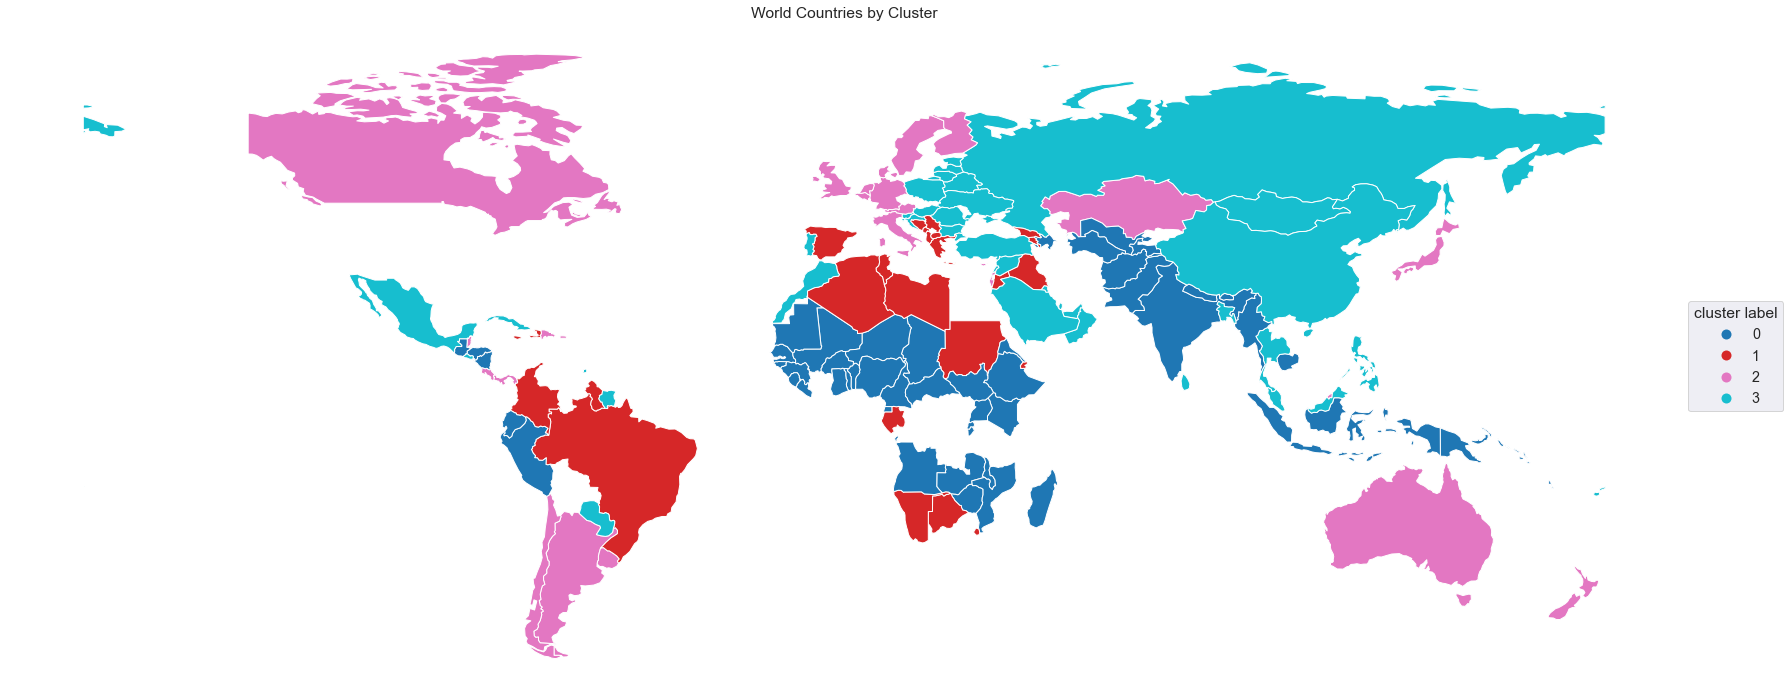

pop_est      continent                 name  gdp_md_est  \
Country_Code                                                             
FJI             920938        Oceania                 Fiji      8374.0   
CAN           35623680  North America               Canada   1674000.0   
KAZ           18556698           Asia           Kazakhstan    460700.0   
UZB           29748859           Asia           Uzbekistan    202300.0   
PNG            6909701        Oceania     Papua New Guinea     28020.0   
...                ...            ...                  ...         ...   
MKD            2103721         Europe            Macedonia     29520.0   
SRB            7111024         Europe               Serbia    101800.0   
MNE             642550         Europe           Montenegro     10610.0   
TTO            1218208  North America  Trinidad and Tobago     43570.0   
SSD           13026129         Africa             S. Sudan     20880.0   

                                                       geometry  labels  
Country_Code                                                             
FJI           MULTIPOLYGON (((180.00000 -16.06713, 180.00000...       3  
CAN           MULTIPOLYGON (((-122.84000 49.00000, -122.9742...       2  
KAZ           POLYGON ((87.35997 49.21498, 86.59878 48.54918...       2  
UZB           POLYGON ((55.96819 41.30864, 55.92892 44.99586...       0  
PNG           MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...       0  
...                                                         ...     ...  
MKD           POLYGON ((22.38053 42.32026, 22.88137 41.99930...       1  
SRB           POLYGON ((18.82982 45.90887, 18.82984 45.90888...       1  
MNE           POLYGON ((20.07070 42.58863, 19.80161 42.50009...       1  
TTO           POLYGON ((-61.68000 10.76000, -61.10500 10.890...       3  
SSD           POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...       0  

[137 rows x 6 columns]

In [150]:
build_geo_df(world,df_cluster,df_pop)

### Get clusters from 2011, assuming K=4 (Scenario 1)

In [225]:
df_11 = merge2complete('2011')

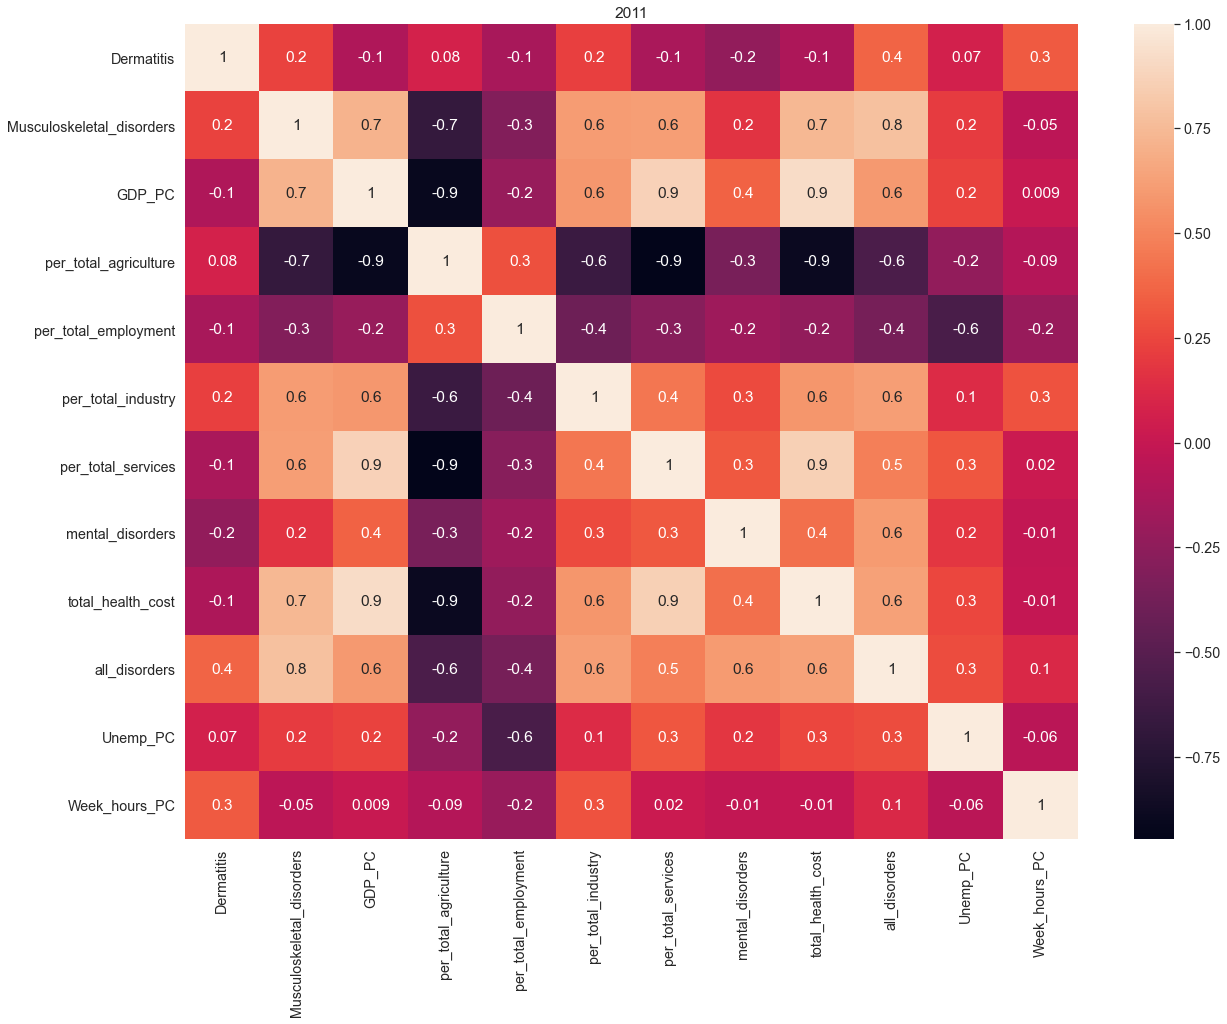

In [226]:
df_11_feat = feature_df(df_11,'2011')

#### Missing Values

In [228]:
pd.DataFrame({'#NA: 2011': df_11_feat.isna().sum()})

#NA: 2011
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             2
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  5
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      0

In [229]:
df_11_gb = (
    df_11_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
)

In [230]:
index_2_remove

Index(['Lesotho', 'South Africa', 'Iceland', 'Ireland', 'Luxembourg', 'Norway',
       'Switzerland', 'Somalia'],
      dtype='object', name='location_name')

In [231]:
#index_2_remove are the countries removed in the df of 2017. Thse are also going to be removed in 2011
df_11_no = df_11_gb.drop(index = list(index_2_remove))

In [232]:
df_11_no.describe().T

count          mean           std          min  \
Dermatitis                 149.0   4724.704143    778.142173  2788.217168   
Musculoskeletal_disorders  149.0   3860.844845   1280.575866  1961.084611   
GDP_PC                     149.0  12696.921063  16842.570477   249.577979   
per_total_agriculture      149.0     28.391074     23.270391     0.110000   
per_total_employment       149.0     57.485033     11.976191    33.090000   
per_total_industry         149.0     19.640403      8.334887     2.130000   
per_total_services         149.0     51.970470     18.146552     9.120000   
mental_disorders           149.0   4554.220530   1289.581298  1891.259135   
total_health_cost          149.0   1054.484582   1257.244382     6.664738   
all_disorders              149.0  13139.769519   2069.999432  9041.484718   
Unemp_PC                   149.0      0.045626      0.031114     0.002548   
Week_hours_PC              149.0     40.138737      4.696058    24.921116   

                                    25%           50%           75%  \
Dermatitis                  4401.276261   4787.664320   5205.368465   
Musculoskeletal_disorders   2786.073003   3752.919322   4799.940562   
GDP_PC                      1516.403915   5322.963760  14392.534256   
per_total_agriculture          7.730000     23.760000     43.720001   
per_total_employment          49.279999     57.279999     64.690002   
per_total_industry            14.750000     19.440001     25.340000   
per_total_services            37.840000     55.040001     66.360001   
mental_disorders            3620.739992   4375.921807   5421.767746   
total_health_cost            128.166150    553.099640   1436.784851   
all_disorders              11545.828055  12893.410632  14579.285830   
Unemp_PC                       0.023669      0.038865      0.053986   
Week_hours_PC                 37.306726     39.897293     42.721283   

                                    max  
Dermatitis                  6474.560792  
Musculoskeletal_disorders   6569.524981  
GDP_PC                     82409.577333  
per_total_agriculture         87.750000  
per_total_employment          86.940002  
per_total_industry            54.110001  
per_total_services            84.769997  
mental_disorders            8895.963290  
total_health_cost           5221.957031  
all_disorders              18936.444518  
Unemp_PC                       0.174065  
Week_hours_PC                 52.461410

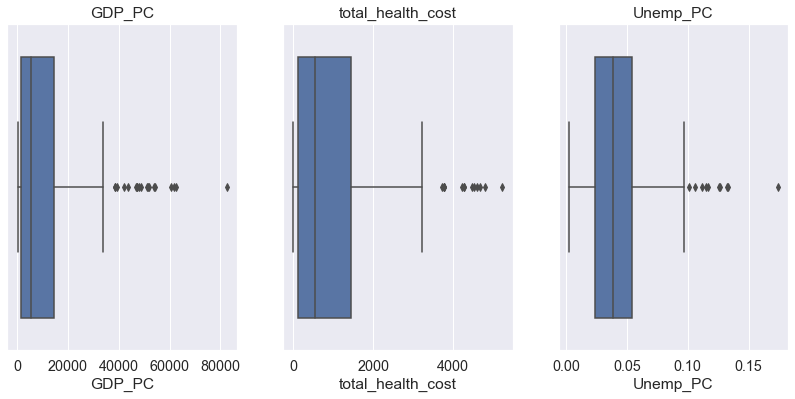

skew      kurt
Dermatitis                -0.403496 -0.049449
Musculoskeletal_disorders  0.351314 -0.871264
GDP_PC                     1.826939  2.694607
per_total_agriculture      0.617291 -0.729400
per_total_employment       0.287555 -0.272881
per_total_industry         0.342647  0.918007
per_total_services        -0.289957 -0.865699
mental_disorders           0.500825  0.009452
total_health_cost          1.628416  1.891009
all_disorders              0.437984 -0.507400
Unemp_PC                   1.332560  1.911132
Week_hours_PC             -0.246038  1.096104

In [235]:
#check outliers. We will not remove them for simplicity and comparison to 2017
eval_outliers(df_11_no,['GDP_PC','total_health_cost','Unemp_PC'])

In [238]:
df_11_no

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                         
Afghanistan    3871.050783                2553.754594    591.162759   
Albania        5342.053593                5562.496536   4437.142885   
Algeria        4658.153190                3818.968263   5462.260897   
Angola         4353.703965                2231.893258   4615.468028   
Argentina      3272.640898                3664.050241  12848.864197   
...                    ...                        ...           ...   
Uruguay        3284.293357                4009.637019  14236.681188   
Uzbekistan     4971.260100                3252.197225   1926.292997   
Vanuatu        4681.507176                4114.927143   3264.537017   
Zambia         4418.660072                1993.715377   1672.908251   
Zimbabwe       4632.180849                2343.651817   1093.654002   

               per_total_agriculture  per_total_employment  \
location_name                                                
Afghanistan                53.560001             42.259998   
Albania                    45.389999             52.020000   
Algeria                    10.770000             38.250000   
Angola                     51.220001             71.709999   
Argentina                   0.640000             56.279999   
...                              ...                   ...   
Uruguay                     9.790000             61.709999   
Uzbekistan                 27.090000             59.480000   
Vanuatu                    64.099998             68.419998   
Zambia                     60.430000             68.190002   
Zimbabwe                   65.860001             78.089996   

               per_total_industry  per_total_services  mental_disorders  \
location_name                                                             
Afghanistan             14.750000           31.690001       5353.402357   
Albania                 18.870001           35.750000       3071.813878   
Algeria                 30.860001           58.369999       5421.767746   
Angola                   7.960000           40.820000       5627.276225   
Argentina               23.969999           75.389999       3734.736042   
...                           ...                 ...               ...   
Uruguay                 20.780001           69.430000       4274.611940   
Uzbekistan              22.740000           50.169998       3314.277117   
Vanuatu                  6.920000           28.980000       2970.821677   
Zambia                   9.360000           30.209999       3544.759996   
Zimbabwe                 9.090000           25.040001       2872.331863   

               total_health_cost  all_disorders  Unemp_PC  Week_hours_PC  
location_name                                                             
Afghanistan           108.015223   11778.207734  0.054972      36.984107  
Albania               480.215637   13976.364008  0.081055      35.917049  
Algeria               687.132324   13898.889198  0.042310      42.242524  
Angola                163.096699   12212.873448  0.056974      39.192026  
Argentina            1852.966370   10671.427182  0.043532      38.404798  
...                          ...            ...       ...            ...  
Uruguay              1553.247559   11568.542317  0.041558      35.868063  
Uzbekistan            280.536118   11537.734442  0.031305      39.737881  
Vanuatu                78.496647   11767.255997  0.012896      27.648823  
Zambia                 74.725624    9957.135445  0.078636      39.695580  
Zimbabwe              141.565559    9848.164529  0.044313      25.662696  

[149 rows x 12 columns]

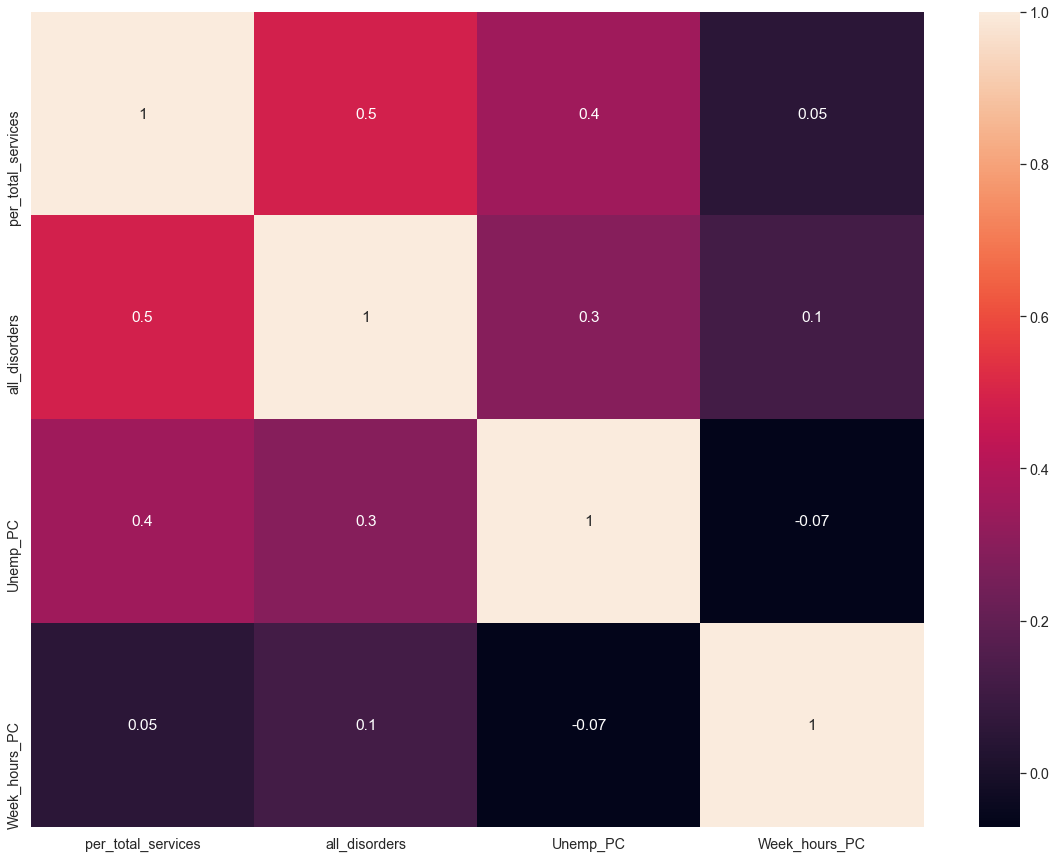

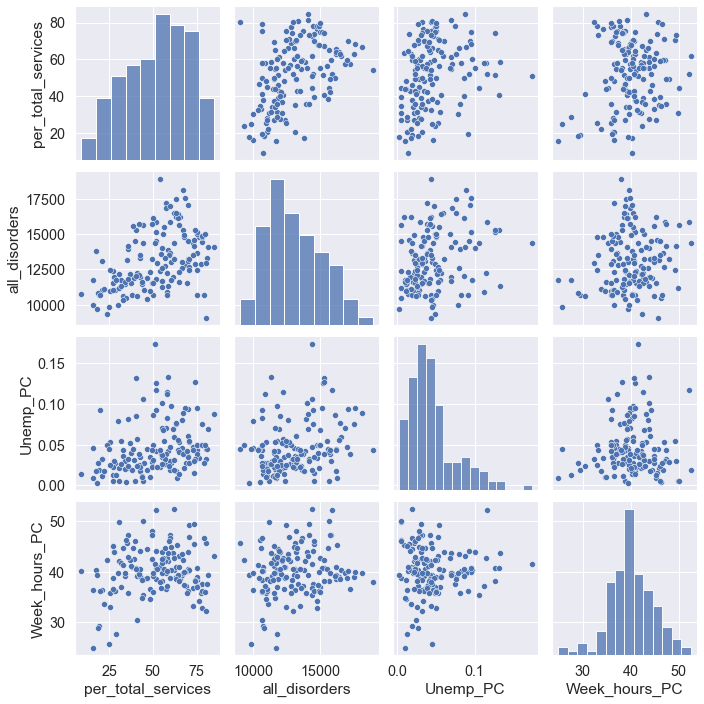

In [239]:
# Correlation is apporx the same as in 2017
cols_eval = ['per_total_services','all_disorders', 'Unemp_PC', 'Week_hours_PC']
             
eval_corr(df_11_no,cols_eval)

In [241]:
df_sc_1_11 = df_11_no[cols_eval]

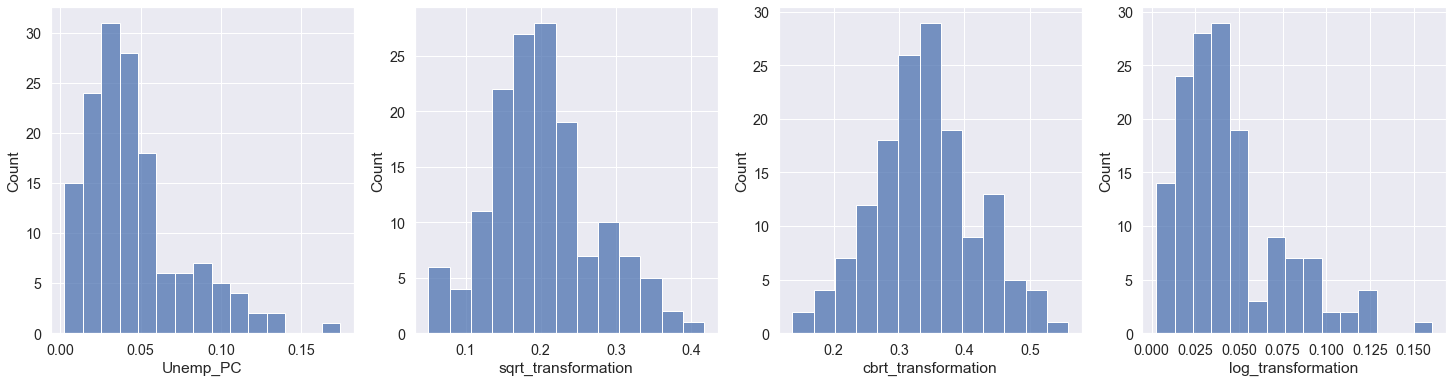

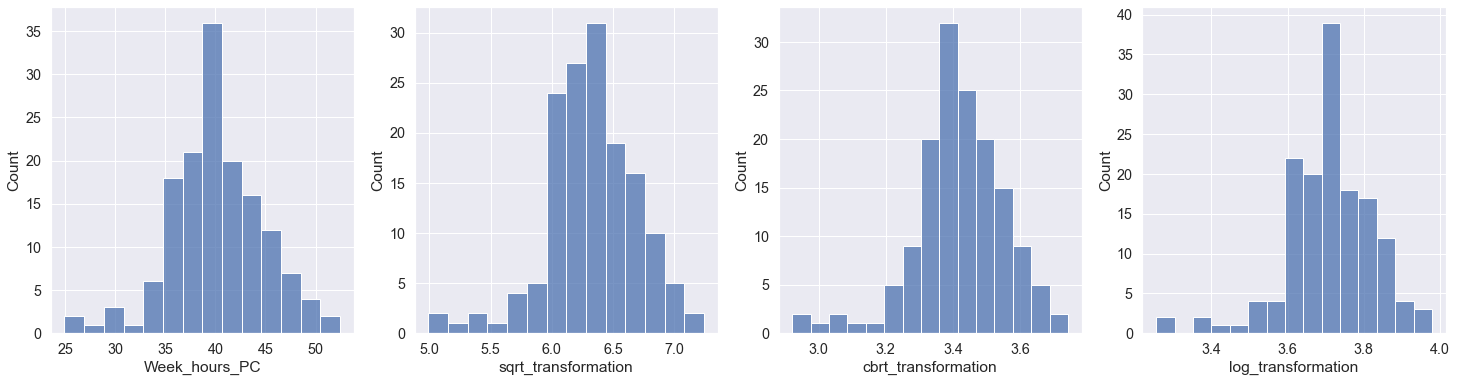

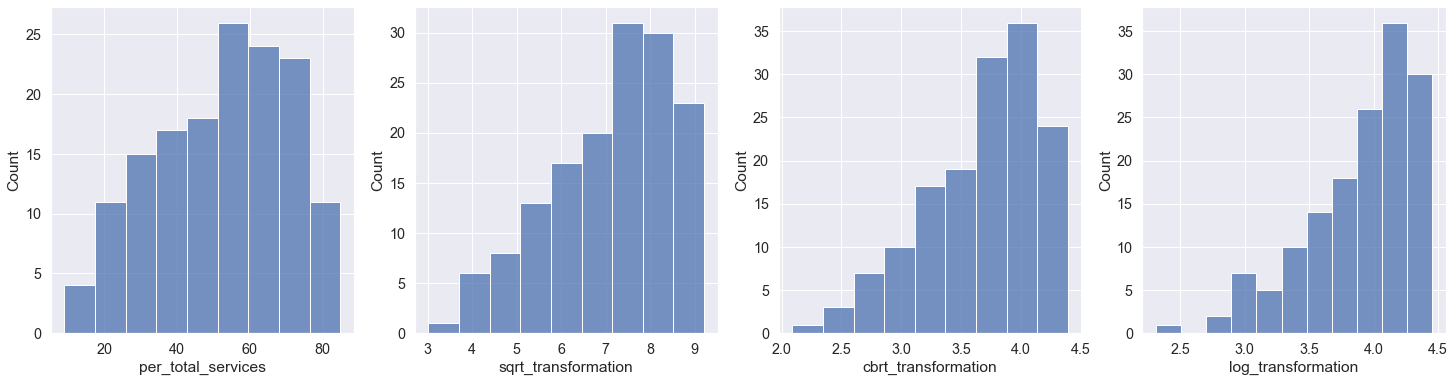

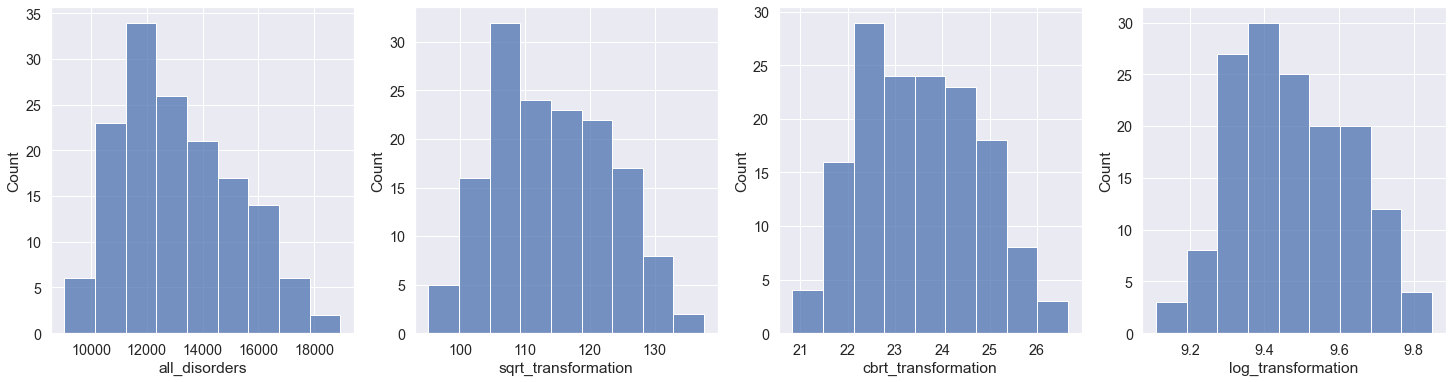

In [242]:
pt_evaluation(df_sc_1_11, 'Unemp_PC')
pt_evaluation(df_sc_1_11, 'Week_hours_PC')
pt_evaluation(df_sc_1_11, 'per_total_services')
pt_evaluation(df_sc_1_11, 'all_disorders')
#pt_evaluation(df_sc_1_11, 'per_total_industry')
#pt_evaluation(df_sc_1_11, 'per_total_employment')

In [243]:
df_sc1_11_t = df_sc_1_11[[]]
df_sc1_11_t = df_sc1_11_t.assign(Unemp_PC_cb = np.cbrt(df_sc_1_11['Unemp_PC']))
df_sc1_11_t = df_sc1_11_t.assign(Week_hours_PC_norm = (df_sc_1_11['Week_hours_PC']))
df_sc1_11_t = df_sc1_11_t.assign(per_total_services_norm = (df_sc_1_11['per_total_services']))
df_sc1_11_t = df_sc1_11_t.assign(all_disorders_cb = np.cbrt(df_sc_1_11['all_disorders']))
#df_sc1_t = df_sc1_11_t.assign(per_total_industry_cb = np.cbrt(df_sc_1_11['per_total_industry']))
#df_sc1_t = df_sc1_11_t.assign(per_total_employment_norm = (df_sc_1_11['per_total_employment']))

In [244]:
minmax = MinMaxScaler()
minmax_sc1_11 = pd.DataFrame(minmax.fit_transform(df_sc1_11_t), columns=df_sc1_11_t.columns)

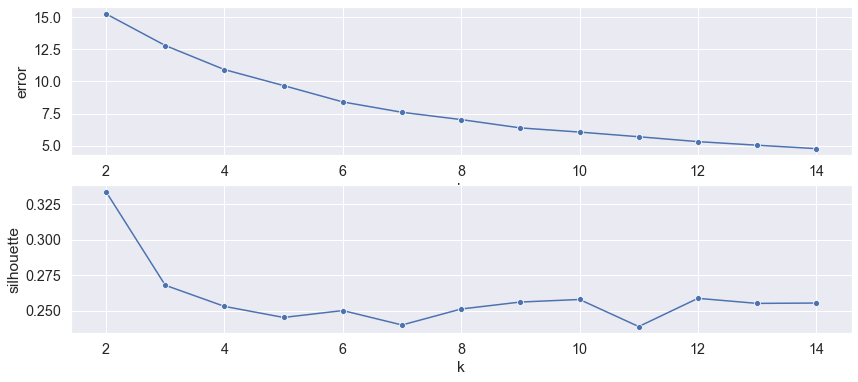

In [245]:
evaluate_number_clusters(minmax_sc1_11,15)

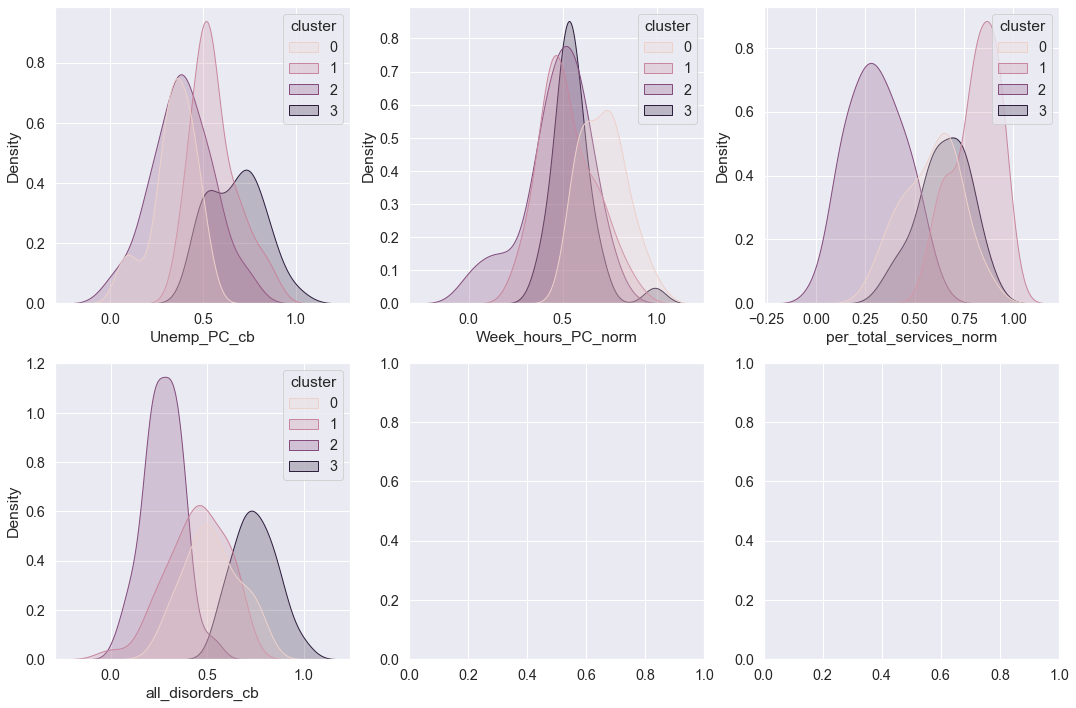

In [247]:
df_cluster_11 = evaluate_cluster(minmax_sc1_11, df_sc_1_11, 4)

In [248]:
df_agg_11 = agreg_clusters(df_cluster_11)
df_agg_11

labels per_total_services all_disorders Unemp_PC Week_hours_PC
        count               mean          mean     mean          mean
labels                                                               
0          32              53.29      13660.57     0.02         44.59
1          40              70.44      12880.10     0.06         39.36
2          48              32.03      11287.50     0.03         37.81
3          29              58.04      15989.08     0.08         40.15

In [252]:
df_agg_17

labels per_total_services all_disorders Unemp_PC Week_hours_PC
        count               mean          mean     mean          mean
labels                                                               
0          54              37.08      11671.05     0.03         38.37
1          26              59.83      14124.97     0.09         41.61
2          30              75.70      13383.33     0.04         37.31
3          39              60.55      15582.74     0.03         42.45